In [ ]:
# Google Colab - Drive bağlantısı ve dataset çıkarma
from google.colab import drive
import zipfile
import os

# Google Drive'ı bağla
drive.mount('/content/drive')

# Dataset zip dosyasının konumu
zip_path = '/content/drive/MyDrive/Dataset/retinalData.zip'
extract_path = '/content/dataset'

# Eğer daha önce çıkarılmadıysa zip dosyasını çıkar
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset başarıyla çıkarıldı!")
else:
    print("Dataset zaten mevcut.")

Mounted at /content/drive
Dataset başarıyla çıkarıldı!


In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading image and label paths

In [ ]:
DATA_ROOT = '/content/dataset'

train_dir = os.path.join(DATA_ROOT, 'Training_Set', 'Training_Set')
val_dir = os.path.join(DATA_ROOT, 'Evaluation_Set', 'Evaluation_Set')
test_dir = os.path.join(DATA_ROOT, 'Test_Set', 'Test_Set')

train_img_paths = glob.glob(os.path.join(train_dir, 'Training', '*.png'))
train_label_path = os.path.join(train_dir, 'RFMiD_Training_Labels.csv')

val_img_paths = glob.glob(os.path.join(val_dir, 'Validation', '*.png'))
val_label_path = os.path.join(val_dir, 'RFMiD_Validation_Labels.csv')

test_img_paths = glob.glob(os.path.join(test_dir, 'Test', '*.png'))
test_label_path = os.path.join(test_dir, 'RFMiD_Testing_Labels.csv')

len(train_img_paths), len(val_img_paths), len(test_img_paths)

(1920, 640, 640)

In [ ]:
train_label_df = pd.read_csv(train_label_path)
val_label_df = pd.read_csv(val_label_path)
test_label_df = pd.read_csv(test_label_path)

print(f'Num. train labels: {len(train_label_df)}')
print(f'Num. val labels: {len(val_label_df)}')
print(f'Num. test labels: {len(test_label_df)}')

Num. train labels: 1920
Num. val labels: 640
Num. test labels: 640


In [ ]:
# show labels in train set
train_label_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`Important note:` the index to the dataframe for each iamge sample is its ID (also name) - 1. With this out of the way, I won't talk about this again in the code below

# Visualizing the dataset

There are 47 columns. Out of which, the `ID` column is the retina image ID, `Disease_Risk` is a binary column representing whether the retina is normal or not. The remaining 45 columns are different types of retina diseases

In [ ]:
train_label_df.columns, len(train_label_df.columns)

(Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
        'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
        'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
        'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
        'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
       dtype='object'),
 47)

Since this is a `multi-label classification` problem, each sample might have zero, one, or more than one true labels. In this case, each retina image might have multiple diseases. Let's plot it out!

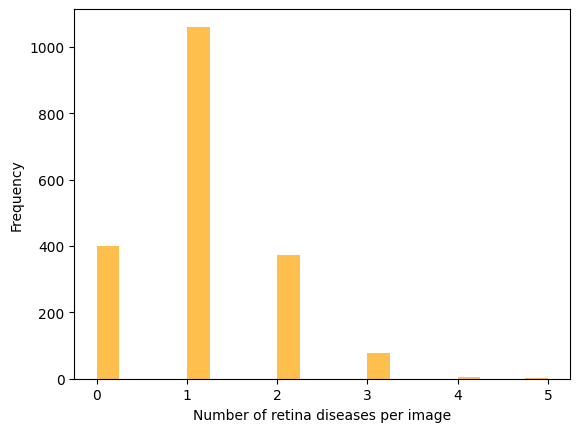

In [ ]:
n_diseases_per_sample = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=1)

plt.hist(n_diseases_per_sample, bins=20, color='orange', alpha=0.7)
plt.xlabel('Number of retina diseases per image')
plt.ylabel('Frequency')
plt.show()

Let's plot a normal retinal image and one with 5 diseases to compare the differences

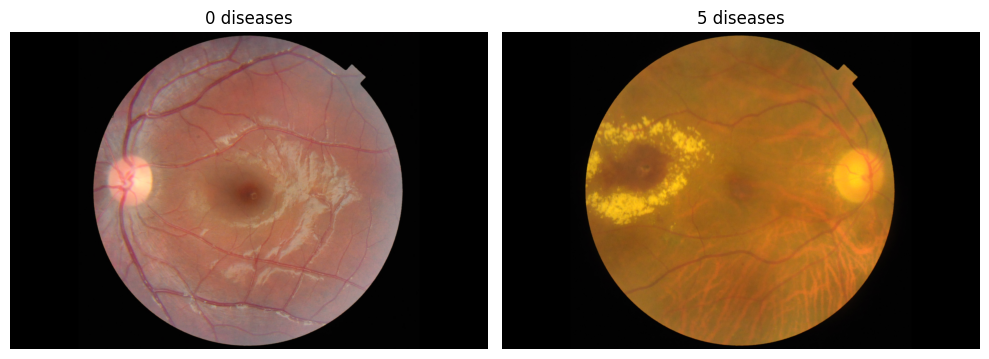

In [ ]:
id_0di = (n_diseases_per_sample == 0).idxmax()
id_5di = (n_diseases_per_sample == 5).idxmax()

img_0di_path = os.path.join(train_dir, 'Training', f'{id_0di+1}.png')
img_5di_path = os.path.join(train_dir, 'Training', f'{id_5di+1}.png')

def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img_0di, img_5di = load_img(img_0di_path), load_img(img_5di_path)

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_0di)
plt.title('0 diseases')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_5di)
plt.title('5 diseases')
plt.axis('off')

plt.tight_layout()
plt.show()

Now let's try from 0 to 5 diseases

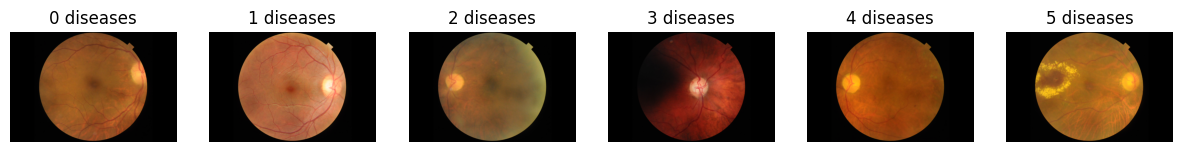

In [ ]:
plt.figure(figsize=(15, 5))
np.random.seed(42)

for i in range(6):  # 0 to 5 diseases
    indices_i = n_diseases_per_sample.index[n_diseases_per_sample == i].tolist()
    if indices_i:
        id_i = np.random.choice(indices_i)  # Get a random index for the current disease count
        img_i_path = os.path.join(train_dir, 'Training', f'{id_i+1}.png')
        img_i = load_img(img_i_path)

        plt.subplot(1, 6, i + 1)
        plt.imshow(img_i)
        plt.title(f'{i} diseases')
        plt.axis('off')

plt.show()

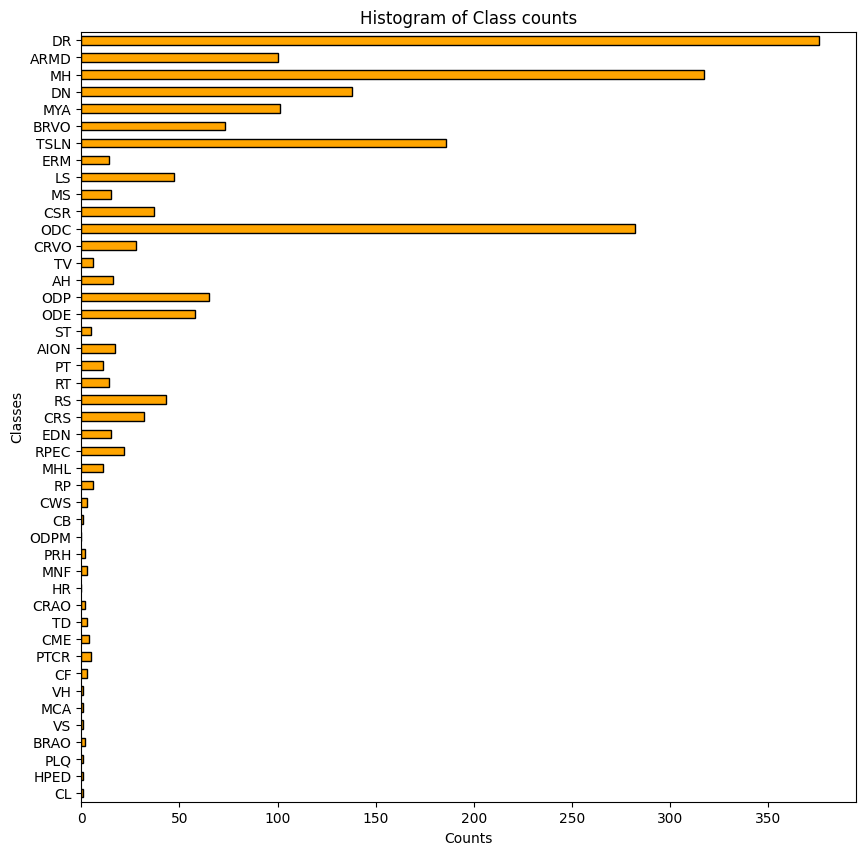

In [ ]:
classes_freq = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=0)[::-1]

plt.figure(figsize=(10, 10))  # Adjust the width and height as needed
classes_freq.plot(kind='barh', color='orange', edgecolor='black')

plt.title('Histogram of Class counts')
plt.xlabel('Counts')
plt.ylabel('Classes')

plt.show()

There are some columns with zero appearance of positive samples so we will need to remove them during training

In [ ]:
classes_freq.loc[classes_freq == 0]

,0
HR,0
ODPM,0


# Preprocessing data for training models

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

def path2id(img_path):
    return int(os.path.splitext(os.path.basename(img_path))[0])

class RetinaDataset(Dataset):

    def __init__(self, img_paths, label_csv_path, transform=None):
        self.img_paths = sorted(img_paths)
        self.label_df = pd.read_csv(label_csv_path).drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM'])
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, id):
        img_path = self.img_paths[id]
        img_id = path2id(img_path)
        img = Image.open(img_path)
        label = np.array(self.label_df.iloc[img_id - 1]) # Index to frame is image ID - 1, see the note earlier
        if self.transform is not None:
            img = self.transform(img)
            label = torch.from_numpy(label).float()
        else:
            img = np.array(img)
        return img, label

In [ ]:
# test the dataset correctness, without transform
ID = 0

data = RetinaDataset(train_img_paths, train_label_path)

img, label = data[ID]
img.shape, img.dtype, label.shape, label.dtype

((1424, 2144, 3), dtype('uint8'), (43,), dtype('int64'))

Below we test out some transformations that PyTorch offers and visualize the result

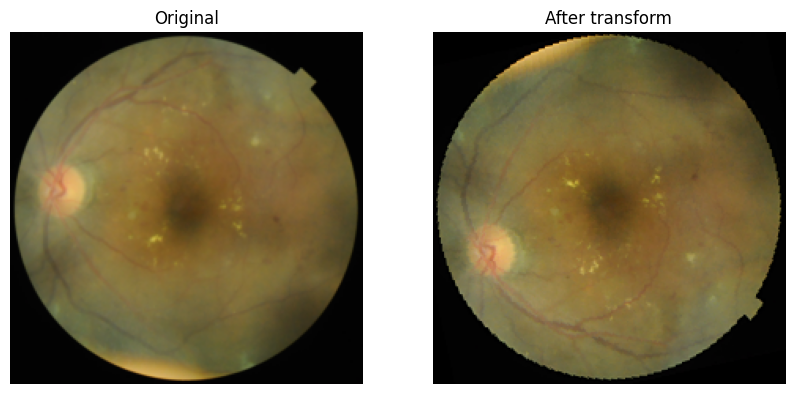

In [ ]:
import torchvision.transforms.v2 as transforms

img_path = train_img_paths[8]
img = Image.open(img_path)

tf1 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

tf2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 1),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
])

img1, img2 = tf1(img), tf2(img)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original')
plt.imshow(img1)

plt.subplot(122)
plt.title('After transform')
plt.imshow(img2)
plt.axis('off')
plt.show()

In [ ]:
(np.array(img1) != np.array(img2)).sum()

np.int64(127706)

In [ ]:
import torchvision.transforms.v2 as transforms

PRET_MEANS = [0.485, 0.456, 0.406]
PRET_STDS = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 0.8),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

In [ ]:
train_data = RetinaDataset(train_img_paths, train_label_path, train_transform)
val_data = RetinaDataset(val_img_paths, val_label_path, test_transform)
test_data = RetinaDataset(test_img_paths, test_label_path, test_transform)

img, label = train_data[ID]
img.shape, img.dtype, label.shape, label.dtype

(torch.Size([3, 224, 224]), torch.float32, torch.Size([43]), torch.float32)

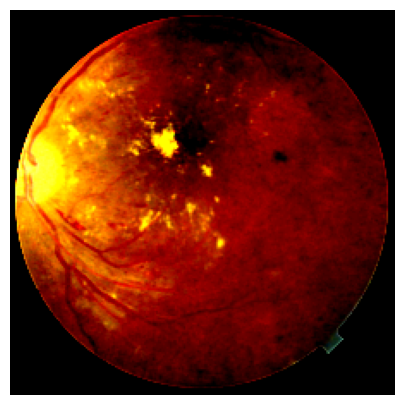

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
# WEIGHT_DECAY = 1e-5
N_WORKERS = os.cpu_count()

train_loader = DataLoader(train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=N_WORKERS,
                           pin_memory=True)

val_loader = DataLoader(val_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

# Model configuration

In [ ]:
from torchvision import models
from torch import nn

model = models.convnext_tiny(weights='IMAGENET1K_V1')

# replace final layer in classifier
in_final = model.classifier[-1].in_features
OUT_FINAL = 43
model.classifier[-1] = nn.Linear(in_final, OUT_FINAL)
model.classifier

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 211MB/s]


Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=43, bias=True)
)

In [ ]:
# Number of parameters
sum(p.numel() for p in model.parameters())

27853195

# Finding suitable Learning Rate

With learning rate annealing from the paper https://arxiv.org/abs/1506.01186

In [ ]:
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm

START_LR = 1e-7

optimizer = optim.AdamW(model.parameters(), lr=START_LR)
loss_fn = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

class LRFinder:

    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def _train_batch(self, iterator):
        self.model.train()
        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = model(x)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def range_test(self, iterator, end_lr=10, num_iter=100,
                    smooth_f=0.05, diverge_th=5):
        lrs=[]
        losses=[]
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)

        for iteration in tqdm(range(num_iter)):
            loss = self._train_batch(iterator)
            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
        return lrs, losses

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        cur_iter = self.last_epoch
        r = cur_iter / self.num_iter
        return [base_lr * ((self.end_lr / base_lr) ** r) for base_lr in self.base_lrs]

class IteratorWrapper():
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, loss_fn, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

 86%|████████▌ | 86/100 [02:00<00:19,  1.41s/it]

Stopping early, the loss has diverged


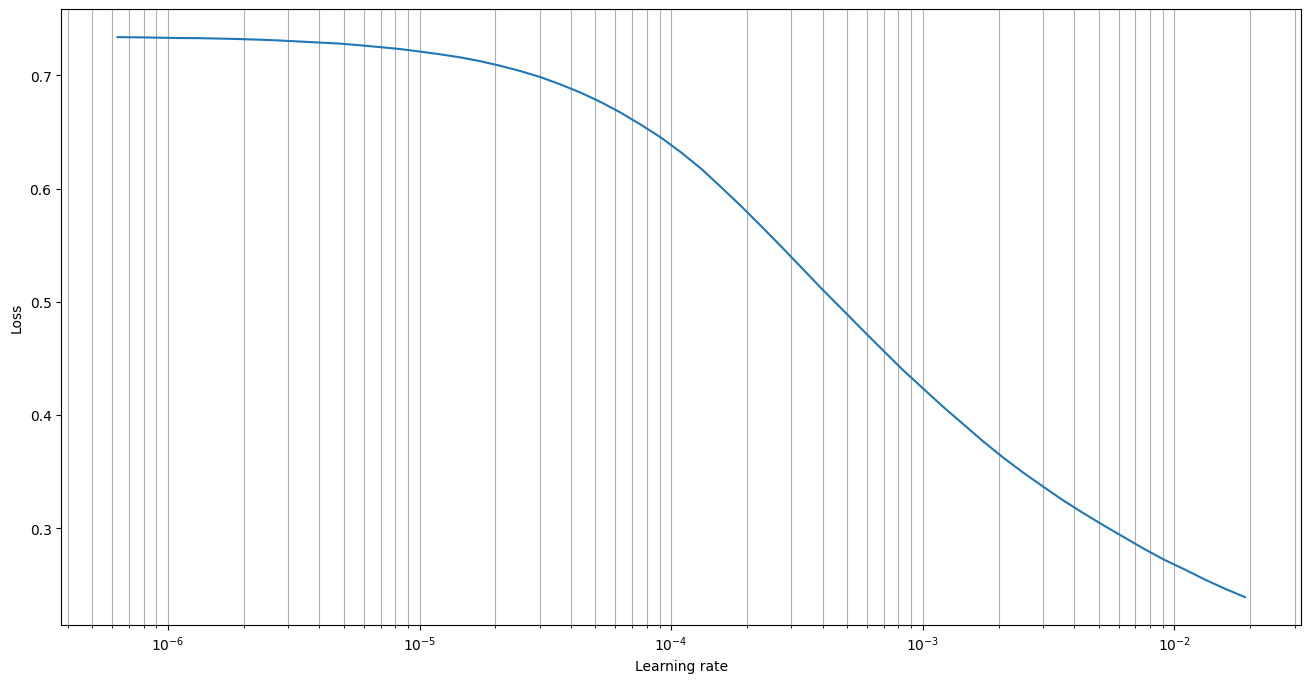

In [ ]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

As explained in the paper, the recommended LR should be the place where the loss is lowest divided by 10. In this case, the suitable LR should be 2e-3

# Training model

We will also use `discriminative fine-tuning` from the paper https://arxiv.org/abs/1801.06146

In [ ]:
LR_FOUND = 2e-3

loss_fn = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

# using smaller learning rate for feature extractor compared to classifier
lr_params = [
    {'params': model.features.parameters(), 'lr': LR_FOUND / 10},
    {'params': model.classifier.parameters(), 'lr': LR_FOUND}
]

optimizer = optim.AdamW(lr_params)

## 🔧 Class Imbalance Çözümleri

Veri setinde ciddi sınıf dengesizliği var. Aşağıda bu problemi çözmek için:
1. **Pos Weight (Class Weighting)**: Nadir sınıflara daha yüksek ağırlık
2. **Focal Loss**: Hard examples'a odaklanma
3. **Gelişmiş Data Augmentation**: RandAugment, ColorJitter, RandomErasing

In [ ]:
# ==========================================
# 1. CLASS WEIGHTING (POS_WEIGHT) HESAPLAMA
# ==========================================

# Her sınıf için pozitif örnek sayısını hesapla
label_cols = train_label_df.drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM']).columns
pos_counts = train_label_df[label_cols].sum()
neg_counts = len(train_label_df) - pos_counts

# pos_weight = negative_samples / positive_samples (nadir sınıflara yüksek ağırlık)
pos_weight = neg_counts / (pos_counts + 1)  # +1 to avoid division by zero
pos_weight = torch.tensor(pos_weight.values, dtype=torch.float32).to(device)

print("Sınıf Ağırlıkları (pos_weight):")
print("-" * 50)
for i, (col, weight) in enumerate(zip(label_cols, pos_weight.cpu().numpy())):
    count = int(pos_counts[col])
    print(f"{col:8s}: {weight:8.2f} (n={count:4d})")

# Weighted BCEWithLogitsLoss
weighted_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

Sınıf Ağırlıkları (pos_weight):
--------------------------------------------------
DR      :     4.10 (n= 376)
ARMD    :    18.02 (n= 100)
MH      :     5.04 (n= 317)
DN      :    12.82 (n= 138)
MYA     :    17.83 (n= 101)
BRVO    :    24.96 (n=  73)
TSLN    :     9.27 (n= 186)
ERM     :   127.07 (n=  14)
LS      :    39.02 (n=  47)
MS      :   119.06 (n=  15)
CSR     :    49.55 (n=  37)
ODC     :     5.79 (n= 282)
CRVO    :    65.24 (n=  28)
TV      :   273.43 (n=   6)
AH      :   112.00 (n=  16)
ODP     :    28.11 (n=  65)
ODE     :    31.56 (n=  58)
ST      :   319.17 (n=   5)
AION    :   105.72 (n=  17)
PT      :   159.08 (n=  11)
RT      :   127.07 (n=  14)
RS      :    42.66 (n=  43)
CRS     :    57.21 (n=  32)
EDN     :   119.06 (n=  15)
RPEC    :    82.52 (n=  22)
MHL     :   159.08 (n=  11)
RP      :   273.43 (n=   6)
CWS     :   479.25 (n=   3)
CB      :   959.50 (n=   1)
PRH     :   639.33 (n=   2)
MNF     :   479.25 (n=   3)
CRAO    :   639.33 (n=   2)
TD      :   479.25 (n

In [ ]:
# ==========================================
# 2. FOCAL LOSS IMPLEMENTATION
# ==========================================
# Focal Loss, kolay öğrenilen örneklerin etkisini azaltır
# ve zor örneklere odaklanır (özellikle nadir sınıflar için faydalı)

class FocalLoss(nn.Module):
    """
    Focal Loss for multi-label classification
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)

    gamma: focusing parameter (0 = BCE, 2 tipik değer)
    alpha: class weighting (pos_weight ile birlikte kullanılabilir)
    """
    def __init__(self, gamma=2.0, alpha=None, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # scalar veya tensor olabilir
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # BCE with logits
        if self.pos_weight is not None:
            bce_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, pos_weight=self.pos_weight, reduction='none'
            )
        else:
            bce_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, reduction='none'
            )

        # Focal term: (1 - p_t)^gamma
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        focal_loss = focal_weight * bce_loss

        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

import torch.nn.functional as F

# Focal Loss with class weighting
focal_loss_fn = FocalLoss(gamma=2.0, pos_weight=pos_weight).to(device)
print("Focal Loss (gamma=2.0) with class weighting oluşturuldu.")

Focal Loss (gamma=2.0) with class weighting oluşturuldu.


In [ ]:
# ==========================================
# 3. GELİŞMİŞ DATA AUGMENTATION
# ==========================================
import torchvision.transforms.v2 as transforms

# Daha agresif augmentation pipeline
advanced_train_transform = transforms.Compose([
    transforms.Resize(256),  # Biraz daha büyük resize

    # Renk augmentation'ları
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),

    # Geometrik augmentation'lar
    transforms.RandomAffine(
        degrees=180,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),

    # Keskinlik ve blur
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),

    # Random erasing (Cutout benzeri)
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

print("Gelişmiş Data Augmentation pipeline oluşturuldu.")
print("Eklenen augmentation'lar:")
print("  - ColorJitter (brightness, contrast, saturation, hue)")
print("  - RandomAffine (rotation, translation, scale, shear)")
print("  - GaussianBlur")
print("  - RandomErasing (Cutout benzeri)")

Gelişmiş Data Augmentation pipeline oluşturuldu.
Eklenen augmentation'lar:
  - ColorJitter (brightness, contrast, saturation, hue)
  - RandomAffine (rotation, translation, scale, shear)
  - GaussianBlur
  - RandomErasing (Cutout benzeri)


In [ ]:
# ==========================================
# 4. WEIGHTED RANDOM SAMPLER (OVERSAMPLING)
# ==========================================
from torch.utils.data import WeightedRandomSampler

# Her örneğe ağırlık ata (içerdiği nadir sınıflara göre)
def calculate_sample_weights(label_df, label_cols):
    """
    Her örnek için ağırlık hesapla.
    Nadir sınıflara sahip örnekler daha yüksek ağırlık alır.
    """
    labels = label_df[label_cols].values
    pos_counts = labels.sum(axis=0)

    # Her sınıfın ağırlığı (ters frekans)
    class_weights = 1.0 / (pos_counts + 1)
    class_weights = class_weights / class_weights.sum()  # normalize

    # Her örneğin ağırlığı = sahip olduğu sınıfların ağırlıklarının toplamı
    sample_weights = (labels * class_weights).sum(axis=1)

    # Hiç hastalığı olmayan örnekler için minimum ağırlık
    sample_weights = np.maximum(sample_weights, sample_weights[sample_weights > 0].min())

    return sample_weights

sample_weights = calculate_sample_weights(train_label_df, label_cols)
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

# WeightedRandomSampler oluştur
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Oversampling için True
)

print(f"Sample weights hesaplandı (min: {sample_weights.min():.6f}, max: {sample_weights.max():.6f})")
print("WeightedRandomSampler oluşturuldu - nadir sınıflar daha sık örneklenecek.")

Sample weights hesaplandı (min: 0.000372, max: 0.080580)
WeightedRandomSampler oluşturuldu - nadir sınıflar daha sık örneklenecek.


In [ ]:
# ==========================================
# 5. YENİ EĞİTİM KURULUMU (TÜM İYİLEŞTİRMELER)
# ==========================================

# Yeni data loader'lar (gelişmiş augmentation + weighted sampler)
train_data_v2 = RetinaDataset(train_img_paths, train_label_path, advanced_train_transform)

train_loader_v2 = DataLoader(
    train_data_v2,
    batch_size=BATCH_SIZE,
    sampler=weighted_sampler,  # shuffle yerine sampler kullan
    num_workers=N_WORKERS,
    pin_memory=True
)

# Model yeniden oluştur (fresh start)
model_v2 = models.convnext_tiny(weights='IMAGENET1K_V1')
in_final = model_v2.classifier[-1].in_features
model_v2.classifier[-1] = nn.Linear(in_final, OUT_FINAL)
model_v2 = model_v2.to(device)

# Discriminative fine-tuning
lr_params_v2 = [
    {'params': model_v2.features.parameters(), 'lr': LR_FOUND / 10},
    {'params': model_v2.classifier.parameters(), 'lr': LR_FOUND}
]
optimizer_v2 = optim.AdamW(lr_params_v2, weight_decay=1e-4)

# Learning rate scheduler (cosine annealing)
scheduler_v2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_v2, T_max=25, eta_min=1e-6)

print("=" * 60)
print("YENİ EĞİTİM KURULUMU TAMAMLANDI")
print("=" * 60)
print("✓ Gelişmiş Data Augmentation (ColorJitter, RandomAffine, etc.)")
print("✓ Weighted Random Sampler (Oversampling)")
print("✓ Focal Loss + Class Weighting (pos_weight)")
print("✓ Cosine Annealing LR Scheduler")
print("✓ Weight Decay: 1e-4")
print("=" * 60)

YENİ EĞİTİM KURULUMU TAMAMLANDI
✓ Gelişmiş Data Augmentation (ColorJitter, RandomAffine, etc.)
✓ Weighted Random Sampler (Oversampling)
✓ Focal Loss + Class Weighting (pos_weight)
✓ Cosine Annealing LR Scheduler
✓ Weight Decay: 1e-4


In [ ]:
# ==========================================
# 6. EĞİTİM DÖNGÜSÜ (İYİLEŞTİRİLMİŞ VERSİYON)
# ==========================================

def accuracy(y_h, y):
    y_h = (y_h > 0.5).float()
    return (y_h == y).float().mean(dim=1).mean()

def eval(model, loader, loss_fn, device):
    model.eval()
    lossi, acci = [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            loss = loss_fn(y_h, y)
            lossi.append(loss.item())

            y_h, y = y_h.detach().cpu(), y.detach().cpu()
            acc = accuracy(y_h, y)
            acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

def train_epoch_v2(model, loader, loss_fn, optimizer, scheduler, device, epoch):
    """Geliştirilmiş training epoch"""
    model.train()
    lossi, acci = [], []

    for x, y in tqdm(loader, desc=f'Epoch {epoch}'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        loss = loss_fn(y_h, y)
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (stabilite için)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        lossi.append(loss.item())

        y_h, y = y_h.detach().cpu(), y.detach().cpu()
        acc = accuracy(y_h, y)
        acci.append(acc)

    scheduler.step()  # LR update

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

# Eğitimi başlat (Focal Loss kullanarak)
N_EPOCHS_V2 = 30
best_loss_v2 = float('inf')
train_resi_v2, val_resi_v2 = [], []
BEST_MODEL_V2 = ''
no_improvement_count_v2 = 0
max_no_improvement_v2 = 5  # Daha sabırlı early stopping

print("\n🚀 İyileştirilmiş model eğitimi başlıyor...")
print(f"Epochs: {N_EPOCHS_V2}, Early stopping patience: {max_no_improvement_v2}\n")

for epoch in range(N_EPOCHS_V2):
    train_res = train_epoch_v2(model_v2, train_loader_v2, focal_loss_fn,
                               optimizer_v2, scheduler_v2, device, epoch+1)
    val_res = eval(model_v2, val_loader, focal_loss_fn, device)

    current_lr = optimizer_v2.param_groups[-1]['lr']

    print(f'Epoch {epoch+1}/{N_EPOCHS_V2} | LR: {current_lr:.2e}')
    print(f"  Train  - Loss: {train_res['loss']:.4f} | Acc: {train_res['acc']:.3f}")
    print(f"  Valid  - Loss: {val_res['loss']:.4f} | Acc: {val_res['acc']:.3f}")

    val_loss = val_res['loss']

    if val_loss < best_loss_v2:
        best_loss_v2 = val_loss
        BEST_MODEL_V2 = f'convnext_imbalance_fixed_cp_{epoch+1}.pth'
        torch.save(model_v2.state_dict(), BEST_MODEL_V2)
        print('  ★ Yeni en iyi model kaydedildi!')
        no_improvement_count_v2 = 0
    else:
        no_improvement_count_v2 += 1
        print(f'  (İyileşme yok: {no_improvement_count_v2}/{max_no_improvement_v2})')

    if no_improvement_count_v2 >= max_no_improvement_v2:
        print(f'\n⚠️ {max_no_improvement_v2} epoch boyunca iyileşme olmadı. Eğitim durduruluyor.')
        break

    train_resi_v2.append(train_res)
    val_resi_v2.append(val_res)
    print()

print(f"\n✅ Eğitim tamamlandı! En iyi model: {BEST_MODEL_V2}")


🚀 İyileştirilmiş model eğitimi başlıyor...
Epochs: 30, Early stopping patience: 5



Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Epoch 1/30 | LR: 1.99e-03
  Train  - Loss: 0.3000 | Acc: 0.957
  Valid  - Loss: 0.4377 | Acc: 0.952
  ★ Yeni en iyi model kaydedildi!



Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


Epoch 2/30 | LR: 1.97e-03
  Train  - Loss: 0.2774 | Acc: 0.955
  Valid  - Loss: 0.5011 | Acc: 0.948
  (İyileşme yok: 1/5)



Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


Epoch 3/30 | LR: 1.93e-03
  Train  - Loss: 0.2004 | Acc: 0.955
  Valid  - Loss: 1.0044 | Acc: 0.962
  (İyileşme yok: 2/5)



Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Epoch 4/30 | LR: 1.88e-03
  Train  - Loss: 0.2201 | Acc: 0.960
  Valid  - Loss: 1.0229 | Acc: 0.952
  (İyileşme yok: 3/5)



Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Epoch 5/30 | LR: 1.81e-03
  Train  - Loss: 0.1580 | Acc: 0.968
  Valid  - Loss: 1.6176 | Acc: 0.962
  (İyileşme yok: 4/5)



Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

Epoch 6/30 | LR: 1.73e-03
  Train  - Loss: 0.1822 | Acc: 0.971
  Valid  - Loss: 0.6782 | Acc: 0.961
  (İyileşme yok: 5/5)

⚠️ 5 epoch boyunca iyileşme olmadı. Eğitim durduruluyor.

✅ Eğitim tamamlandı! En iyi model: convnext_imbalance_fixed_cp_1.pth


In [ ]:
# ==========================================
# 7. KARŞILAŞTIRMALI DEĞERLENDİRME
# ==========================================

# Definitions of true_positive, false_positive, false_negative
# (Copied from cell 305f4736 to resolve NameError)
def true_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    true_positive = torch.sum((y_pred == 1) & (y_true == 1), dim=0)
    return true_positive

def false_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_positive = torch.sum((y_pred == 1) & (y_true == 0), dim=0)
    return false_positive

def false_negative(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_negative = torch.sum((y_pred == 0) & (y_true == 1), dim=0)
    return false_negative

# Definition of eval3
# (Copied from cell 9209b5c8 to resolve NameError)
def eval3(model, loader, device):
    true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation on 3 metrics'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            y_h, y = y_h.detach().cpu(), y.detach().cpu()

            tp = true_positive(y_h, y)
            fp = false_positive(y_h, y)
            fn = false_negative(y_h, y)

            true_pos += tp; false_pos += fp; false_neg += fn

    precision = true_pos / (true_pos + false_pos + 1e-10)
    recall = true_pos / (true_pos + false_neg + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return {
        'precision': precision, 'recall': recall, 'f1': f1
    }

# Ensure `test_result` for the original model is available for comparison.
# Since `BEST_MODEL` (path to the original model's checkpoint) is not consistently available
# in the kernel state, we will evaluate the `model` object as it stands.
# This provides a baseline comparison, even if the original model was not fully trained
# in this specific session run due to skipped cells.

if 'BEST_MODEL' not in globals() or not globals()['BEST_MODEL']:
    print("WARNING: Original model's best checkpoint path (BEST_MODEL) is not defined or empty.")
    print("         Calculating 'test_result' for the currently configured 'model' (potentially untrained). \
         This will serve as a baseline for comparison.")
    # Ensure the original `model` is on the correct device for evaluation
    model = model.to(device)
    test_result = eval3(model, test_loader, device)
else:
    print(f"Loading original model from: {BEST_MODEL}")
    # Load the best original model state
    model.load_state_dict(torch.load(BEST_MODEL))
    test_result = eval3(model, test_loader, device)

# İyileştirilmiş modeli yükle ve test et
model_v2.load_state_dict(torch.load(BEST_MODEL_V2))
test_result_v2 = eval3(model_v2, test_loader, device)

# Orijinal model sonuçları ile karşılaştır
print("=" * 70)
print("📊 MODEL KARŞILAŞTIRMASI (Test Seti)")
print("=" * 70)

# Class bazında karşılaştırma
print(f"\n{'Sınıf':<8} | {'Orijinal F1':>12} | {'İyileştirilmiş F1':>17} | {'Fark':>8}")
print("-" * 55)

improvements = []
for i, col in enumerate(label_cols):
    # Ensure test_result has 'f1' key and is accessible
    orig_f1 = test_result['f1'][i].item() if 'f1' in test_result and i < len(test_result['f1']) else 0
    new_f1 = test_result_v2['f1'][i].item()
    diff = new_f1 - orig_f1
    improvements.append(diff)

    # Nadir sınıfları vurgula
    count = int(pos_counts[col])
    marker = "🔴" if count < 50 else "🟡" if count < 100 else ""

    print(f"{col:<8} | {orig_f1:>12.3f} | {new_f1:>17.3f} | {diff:>+8.3f} {marker}")

# Özet istatistikler
print("-" * 55)
print(f"\n📈 Ortalama F1 İyileşmesi: {np.mean(improvements):+.3f}")
print(f"📈 Nadir Sınıflarda (<50 örnek) Ortalama İyileşme: ", end="")
rare_improvements = [improvements[i] for i, col in enumerate(label_cols) if pos_counts[col] < 50]
print(f"{np.mean(rare_improvements):+.3f}" if rare_improvements else "N/A")

         Calculating 'test_result' for the currently configured 'model' (potentially untrained).          This will serve as a baseline for comparison.


Evaluation on 3 metrics: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]

📊 MODEL KARŞILAŞTIRMASI (Test Seti)

Sınıf    |  Orijinal F1 | İyileştirilmiş F1 |     Fark
-------------------------------------------------------
DR       |        0.222 |             0.000 |   -0.222 
ARMD     |        0.000 |             0.000 |   +0.000 
MH       |        0.052 |             0.000 |   -0.052 
DN       |        0.000 |             0.000 |   +0.000 
MYA      |        0.000 |             0.000 |   +0.000 
BRVO     |        0.000 |             0.000 |   +0.000 🟡
TSLN     |        0.000 |             0.000 |   +0.000 
ERM      |        0.000 |             0.000 |   +0.000 🔴
LS       |        0.000 |             0.000 |   +0.000 🔴
MS       |        0.031 |             0.000 |   -0.031 🔴
CSR      |        0.000 |             0.000 |   +0.000 🔴
ODC      |        0.000 |             0.000 |   +0.000 
CRVO     |        0.000 |             0.400 |   +0.400 🔴
TV       |        0.000 |             0.000 |   +0.000 🔴
AH       |        0.014 |             0.000 |   -0.014 🔴
ODP 

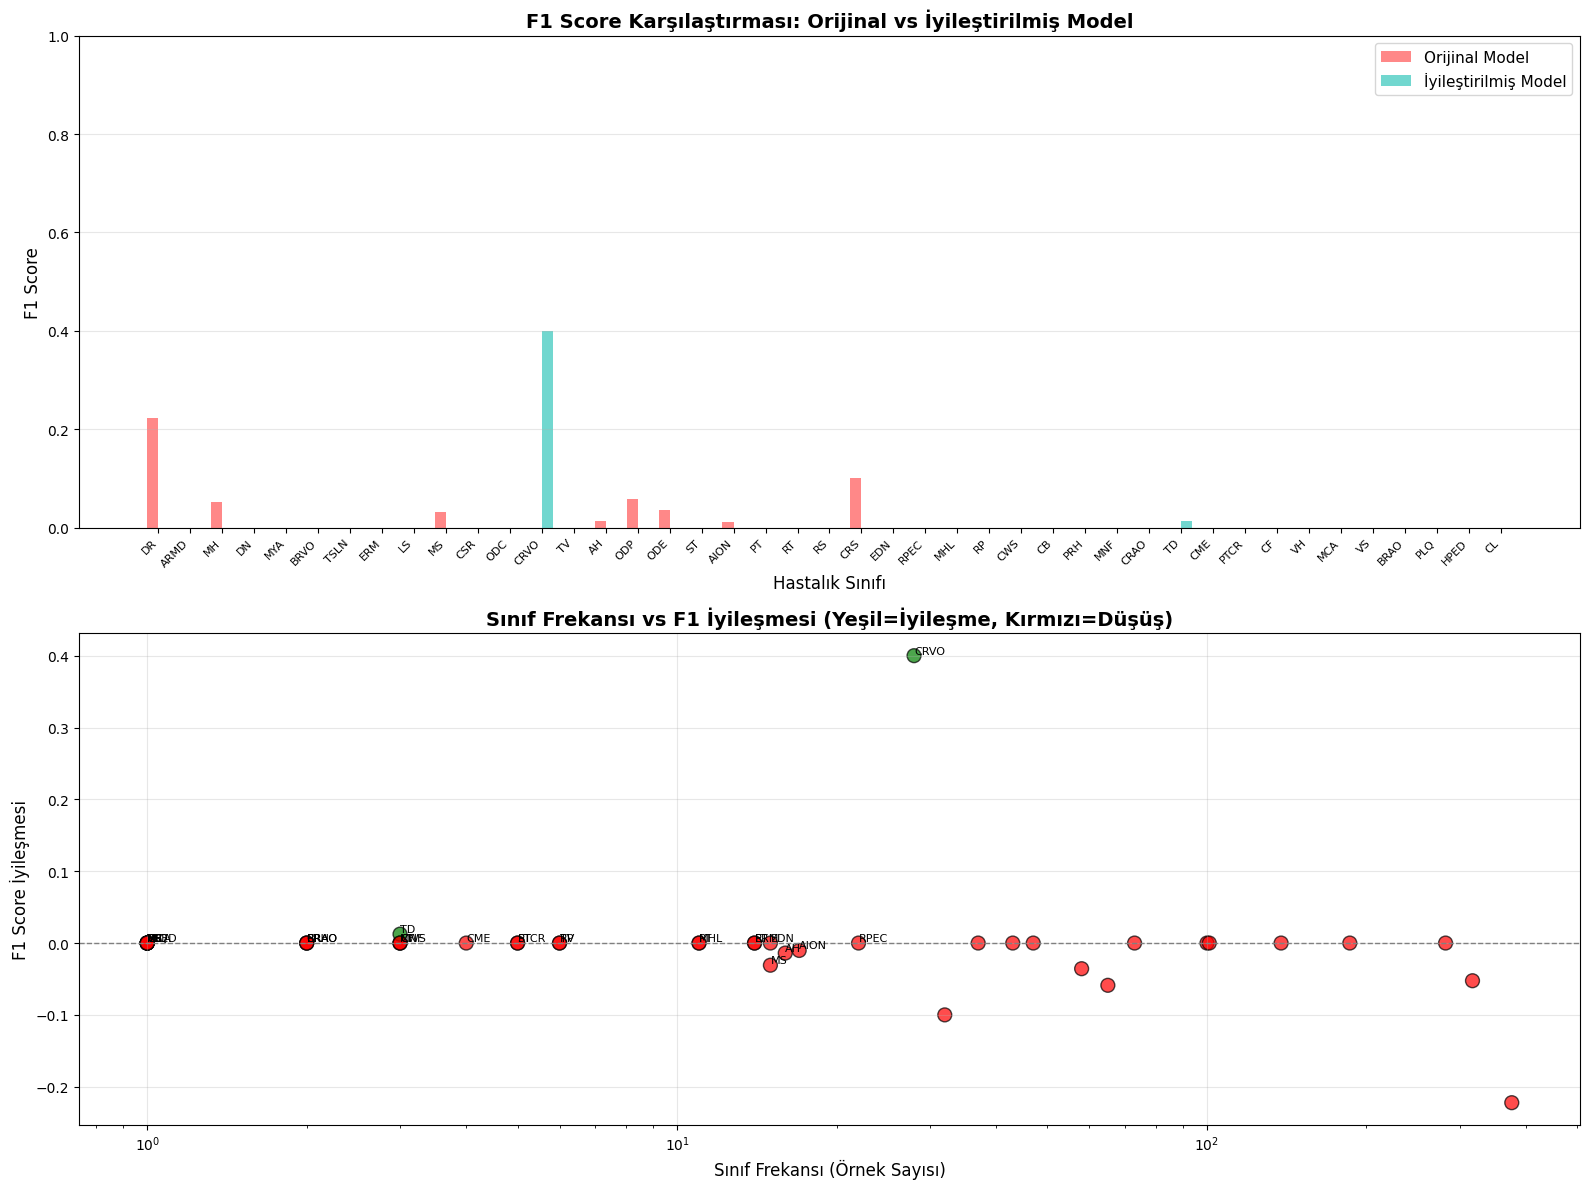


📊 Grafik 'model_comparison_imbalance_fix.png' olarak kaydedildi.


In [ ]:
# ==========================================
# 8. GÖRSELLEŞTİRME: ESKİ vs YENİ MODEL
# ==========================================

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

bar_width = 0.35
index = np.arange(OUT_FINAL)

# F1 Score karşılaştırması
ax1 = axes[0]
orig_f1 = test_result['f1'].numpy() if hasattr(test_result['f1'], 'numpy') else np.zeros(OUT_FINAL)
new_f1 = test_result_v2['f1'].numpy()

bars1 = ax1.bar(index, orig_f1, bar_width, label='Orijinal Model', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(index + bar_width, new_f1, bar_width, label='İyileştirilmiş Model', color='#4ECDC4', alpha=0.8)

ax1.set_xlabel('Hastalık Sınıfı', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
ax1.set_title('F1 Score Karşılaştırması: Orijinal vs İyileştirilmiş Model', fontsize=14, fontweight='bold')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(label_cols, rotation=45, ha='right', fontsize=8)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1)

# Class frequency vs F1 improvement
ax2 = axes[1]
class_freqs = pos_counts.values
f1_improvements = new_f1 - orig_f1

colors = ['green' if x > 0 else 'red' for x in f1_improvements]
scatter = ax2.scatter(class_freqs, f1_improvements, c=colors, s=100, alpha=0.7, edgecolors='black')

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel('Sınıf Frekansı (Örnek Sayısı)', fontsize=12)
ax2.set_ylabel('F1 Score İyileşmesi', fontsize=12)
ax2.set_title('Sınıf Frekansı vs F1 İyileşmesi (Yeşil=İyileşme, Kırmızı=Düşüş)', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# Nadir sınıfları etiketle
for i, col in enumerate(label_cols):
    if class_freqs[i] < 30:  # Çok nadir sınıflar
        ax2.annotate(col, (class_freqs[i], f1_improvements[i]),
                    fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.savefig('model_comparison_imbalance_fix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Grafik 'model_comparison_imbalance_fix.png' olarak kaydedildi.")

In [ ]:
# ==========================================
# 9. CONFUSION MATRIX - İYİLEŞTİRİLMİŞ MODEL
# ==========================================
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# İyileştirilmiş model için tahminleri topla
all_preds_v2 = []
all_labels_v2 = []

model_v2.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Collecting predictions (improved model)'):
        x = x.to(device)
        y_h = model_v2(x)
        y_h = torch.sigmoid(y_h)
        all_preds_v2.append(y_h.cpu())
        all_labels_v2.append(y.cpu())

all_preds_v2 = torch.cat(all_preds_v2, dim=0)
all_labels_v2 = torch.cat(all_labels_v2, dim=0)

# Binary predictions (threshold = 0.5)
all_preds_binary_v2 = (all_preds_v2 > 0.5).float()

print(f"✅ Test örnekleri: {len(all_preds_v2)}")
print(f"✅ Sınıf sayısı: {OUT_FINAL}")

✅ Test örnekleri: 640
✅ Sınıf sayısı: 43


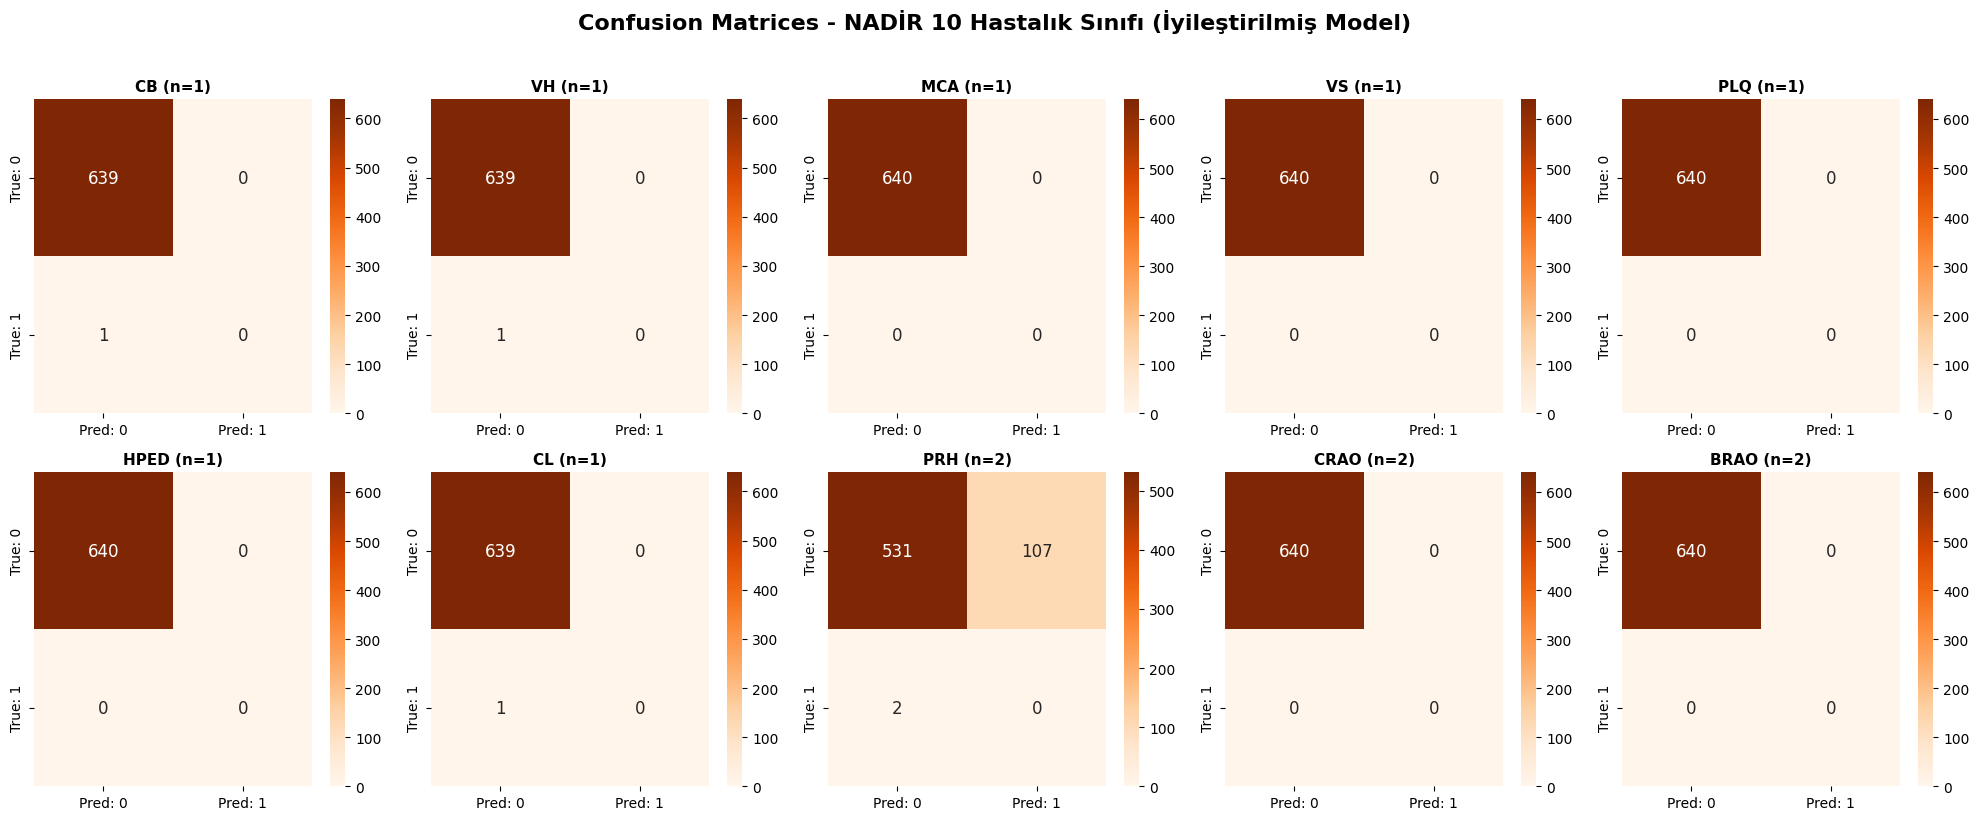


📊 Grafik 'confusion_matrices_rare_classes_v2.png' olarak kaydedildi.


In [ ]:
# ==========================================
# 10. CONFUSION MATRIX GRİD - NADİR SINIFLAR
# ==========================================
# En az örneği olan 10 sınıf için confusion matrix

# Sınıf frekanslarını al
class_counts = pos_counts.copy()

# En az örneği olan 10 sınıf
bottom_10_classes = class_counts.nsmallest(10).index.tolist()
bottom_10_indices = [list(label_cols).index(c) for c in bottom_10_classes]

# Multi-label confusion matrix hesapla
mcm_v2 = multilabel_confusion_matrix(all_labels_v2.numpy(), all_preds_binary_v2.numpy())

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (class_idx, class_name) in enumerate(zip(bottom_10_indices, bottom_10_classes)):
    cm = mcm_v2[class_idx]
    count = int(class_counts[class_name])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 12})
    axes[idx].set_title(f'{class_name} (n={count})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - NADİR 10 Hastalık Sınıfı (İyileştirilmiş Model)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_rare_classes_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Grafik 'confusion_matrices_rare_classes_v2.png' olarak kaydedildi.")

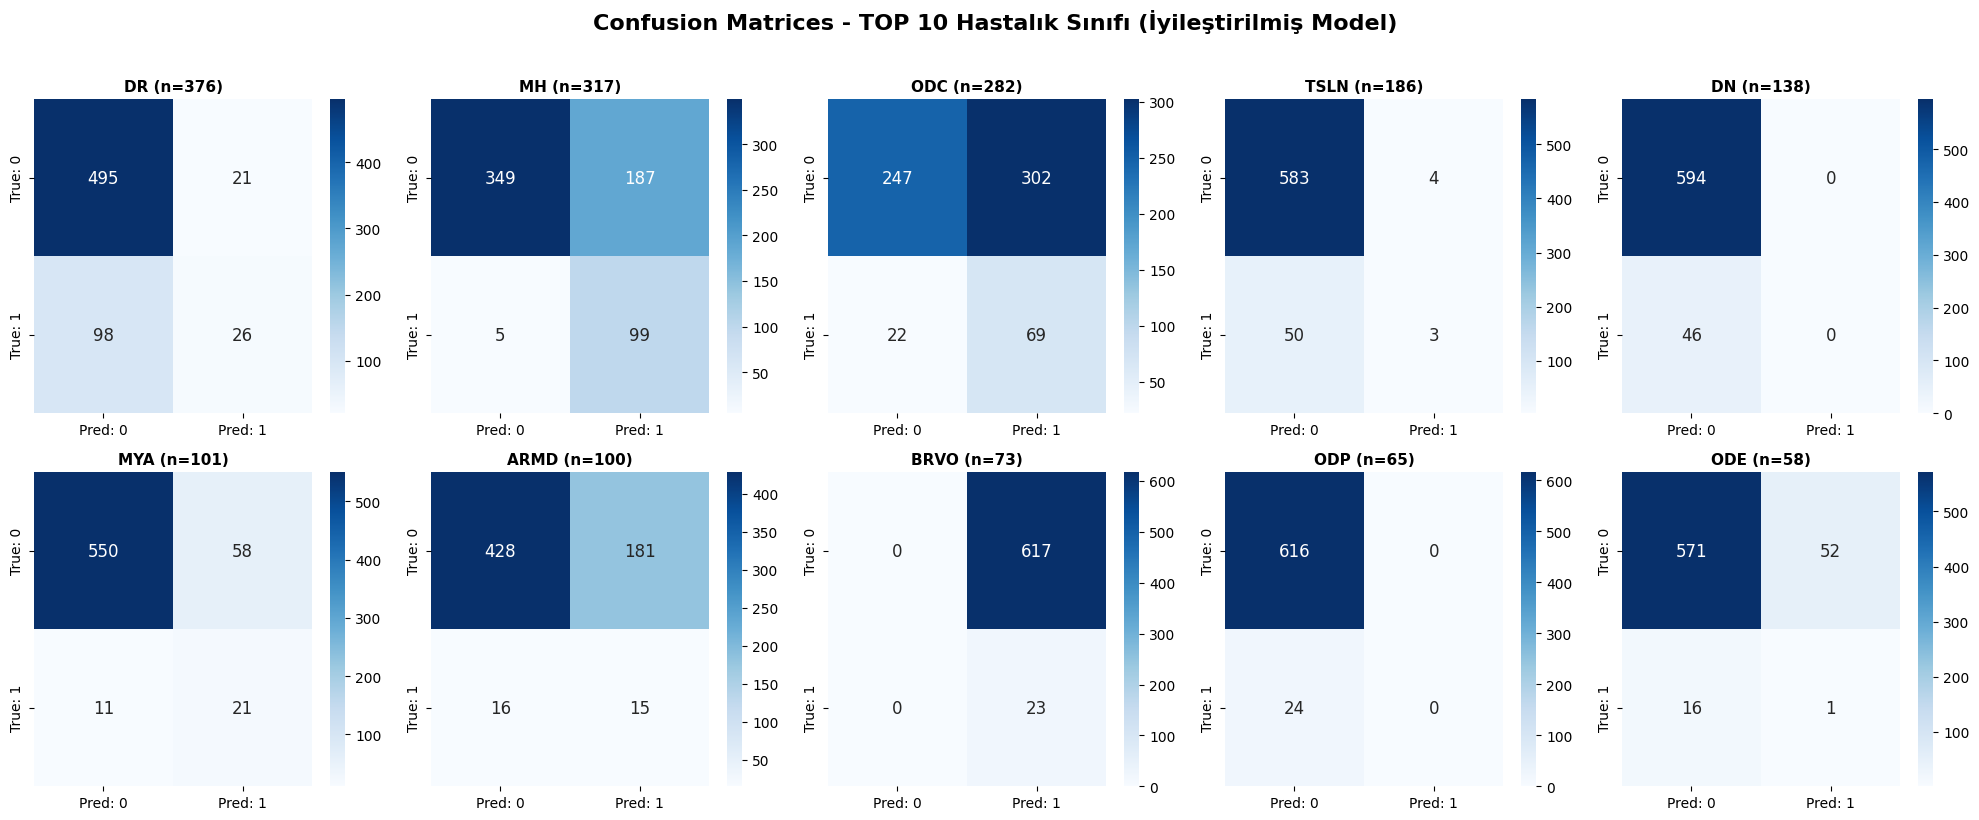


📊 Grafik 'confusion_matrices_top10_v2.png' olarak kaydedildi.


In [ ]:
# ==========================================
# 11. CONFUSION MATRIX GRİD - EN YAYGIN SINIFLAR
# ==========================================
# En çok örneği olan 10 sınıf için confusion matrix

top_10_classes = class_counts.nlargest(10).index.tolist()
top_10_indices = [list(label_cols).index(c) for c in top_10_classes]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (class_idx, class_name) in enumerate(zip(top_10_indices, top_10_classes)):
    cm = mcm_v2[class_idx]
    count = int(class_counts[class_name])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 12})
    axes[idx].set_title(f'{class_name} (n={count})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - TOP 10 Hastalık Sınıfı (İyileştirilmiş Model)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_top10_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Grafik 'confusion_matrices_top10_v2.png' olarak kaydedildi.")

In [ ]:
# ==========================================
# 12. TÜM SINIFLARIN ÖZET CONFUSION MATRİX TABLOSU
# ==========================================
from tabulate import tabulate

# Her sınıf için TP, FP, FN, TN hesapla
summary_data = []

for i, class_name in enumerate(label_cols):
    cm = mcm_v2[i]
    tn, fp, fn, tp = cm.ravel()

    # Metrikler
    precision_i = tp / (tp + fp + 1e-10)
    recall_i = tp / (tp + fn + 1e-10)
    f1_i = 2 * precision_i * recall_i / (precision_i + recall_i + 1e-10)
    specificity_i = tn / (tn + fp + 1e-10)

    count = int(class_counts[class_name])

    summary_data.append({
        'Sınıf': class_name,
        'Örnek': count,
        'TP': int(tp),
        'FP': int(fp),
        'FN': int(fn),
        'TN': int(tn),
        'Precision': f'{precision_i:.3f}',
        'Recall': f'{recall_i:.3f}',
        'F1': f'{f1_i:.3f}',
        'Specificity': f'{specificity_i:.3f}'
    })

# DataFrame olarak göster
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Örnek', ascending=False)

print("=" * 100)
print("📊 TÜM SINIFLARIN CONFUSION MATRIX ÖZETİ (İyileştirilmiş Model)")
print("=" * 100)
print(summary_df.to_string(index=False))

# CSV olarak kaydet
summary_df.to_csv('confusion_matrix_summary_v2.csv', index=False)
print("\n✅ Özet tablo 'confusion_matrix_summary_v2.csv' olarak kaydedildi.")

📊 TÜM SINIFLARIN CONFUSION MATRIX ÖZETİ (İyileştirilmiş Model)
Sınıf  Örnek  TP  FP  FN  TN Precision Recall    F1 Specificity
   DR    376  26  21  98 495     0.553  0.210 0.304       0.959
   MH    317  99 187   5 349     0.346  0.952 0.508       0.651
  ODC    282  69 302  22 247     0.186  0.758 0.299       0.450
 TSLN    186   3   4  50 583     0.429  0.057 0.100       0.993
   DN    138   0   0  46 594     0.000  0.000 0.000       1.000
  MYA    101  21  58  11 550     0.266  0.656 0.378       0.905
 ARMD    100  15 181  16 428     0.077  0.484 0.132       0.703
 BRVO     73  23 617   0   0     0.036  1.000 0.069       0.000
  ODP     65   0   0  24 616     0.000  0.000 0.000       1.000
  ODE     58   1  52  16 571     0.019  0.059 0.029       0.917
   LS     47   7 211   8 414     0.032  0.467 0.060       0.662
   RS     43  14 578   0  48     0.024  1.000 0.046       0.077
  CSR     37   0   0  13 627     0.000  0.000 0.000       1.000
  CRS     32  11 619   0  10     0.017  1

We'll use precision, recall, and (macro) F1 score as our evaluation metrics

In [ ]:
def accuracy(y_h, y):
    y_h = (y_h > 0.5).float()
    return (y_h == y).float().mean(dim=1).mean()

def train_epoch(model, loader, loss_fn, optimizer, device, epoch):
    model.train()
    lossi, acci = [], []

    for x, y in tqdm(loader, desc=f'Epoch {epoch}'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        loss = loss_fn(y_h, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

        y_h, y = y_h.detach().cpu(), y.detach().cpu()
        acc = accuracy(y_h, y)
        acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

def eval(model, loader, loss_fn, device):
    model.eval()
    lossi, acci = [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            loss = loss_fn(y_h, y)
            lossi.append(loss.item())

            y_h, y = y_h.detach().cpu(), y.detach().cpu()
            acc = accuracy(y_h, y)
            acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

In [ ]:
N_EPOCHS = 25
best_loss = float('inf')

train_resi, val_resi = [], []
BEST_MODEL = ''

no_improvement_count = 0
max_no_improvement = 3  # Set the threshold for consecutive epochs without improvement

for epoch in range(N_EPOCHS):
    train_res = train_epoch(model, train_loader, loss_fn, optimizer, device, epoch+1)
    val_res = eval(model, val_loader, loss_fn, device)

    print('- Train')
    print(f"  Loss: {train_res['loss']: 3.4f} | "
          f"Accuracy: {train_res['acc']: .3f}")

    print('- Validation')
    print(f"  Loss: {val_res['loss']: 3.4f} | "
          f"Accuracy: {val_res['acc']: .3f}")

    val_loss = val_res['loss']

    if val_loss < best_loss:
        best_loss = val_loss
        BEST_MODEL = f'convnext_cp_{epoch+1}.pth'
        torch.save(model.state_dict(), BEST_MODEL)
        print('* Current best loss. Saved model!')
        no_improvement_count = 0  # Reset the counter since there's an improvement
    else:
        no_improvement_count += 1

    if no_improvement_count >= max_no_improvement:
        print(f'No improvement in validation loss for {max_no_improvement} consecutive epochs. Stopping training.')
        break

    train_resi.append(train_res)
    val_resi.append(val_res)

Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


- Train
  Loss:  0.1338 | Accuracy:  0.972
- Validation
  Loss:  0.0769 | Accuracy:  0.977
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


- Train
  Loss:  0.0681 | Accuracy:  0.979
- Validation
  Loss:  0.0674 | Accuracy:  0.979
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


- Train
  Loss:  0.0544 | Accuracy:  0.982
- Validation
  Loss:  0.0607 | Accuracy:  0.981
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


- Train
  Loss:  0.0460 | Accuracy:  0.984
- Validation
  Loss:  0.0541 | Accuracy:  0.982
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


- Train
  Loss:  0.0392 | Accuracy:  0.986
- Validation
  Loss:  0.0544 | Accuracy:  0.982


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


- Train
  Loss:  0.0340 | Accuracy:  0.988
- Validation
  Loss:  0.0523 | Accuracy:  0.984
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


- Train
  Loss:  0.0305 | Accuracy:  0.989
- Validation
  Loss:  0.0518 | Accuracy:  0.983
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


- Train
  Loss:  0.0241 | Accuracy:  0.991
- Validation
  Loss:  0.0527 | Accuracy:  0.984


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


- Train
  Loss:  0.0207 | Accuracy:  0.992
- Validation
  Loss:  0.0551 | Accuracy:  0.984


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

- Train
  Loss:  0.0183 | Accuracy:  0.993
- Validation
  Loss:  0.0560 | Accuracy:  0.984
No improvement in validation loss for 3 consecutive epochs. Stopping training.


# Model evaluation

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL))

<All keys matched successfully>

In [ ]:
import json

SAVE_RES = {
    'train': train_resi,
    'val': val_resi
}

with open('convnext_retina_result.json', 'w') as f:
    json.dump(SAVE_RES, f)

In [ ]:
def true_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    true_positive = torch.sum((y_pred == 1) & (y_true == 1), dim=0)
    return true_positive

def false_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_positive = torch.sum((y_pred == 1) & (y_true == 0), dim=0)
    return false_positive

def false_negative(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_negative = torch.sum((y_pred == 0) & (y_true == 1), dim=0)
    return false_negative

In [ ]:
# test function correctness
y_true = torch.tensor([[0,1,1,0], [0,1,0,1]])
y_pred = torch.tensor([[0,1,0,1], [1,0,0,1]])

print('True positive:', true_positive(y_pred, y_true))
print('False positive:', false_positive(y_pred, y_true))
print('False negative:', false_negative(y_pred, y_true))

True positive: tensor([0, 1, 0, 1])
False positive: tensor([1, 0, 0, 1])
False negative: tensor([0, 1, 1, 0])


For our model result, we would want a high recall and a good precision as as missed diagnosis is bad while a wrong prediction might not be so life-threatening

In [ ]:
true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

model.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        y_h, y = y_h.detach().cpu(), y.detach().cpu()

        tp = true_positive(y_h, y)
        fp = false_positive(y_h, y)
        fn = false_negative(y_h, y)

        true_pos += tp; false_pos += fp; false_neg += fn

Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


In [ ]:
precision = true_pos / (true_pos + false_pos + 1e-10)
precision

tensor([0.7842, 0.7692, 0.8235, 0.5000, 0.7500, 0.8125, 0.7941, 0.0000, 1.0000,
        0.0000, 1.0000, 0.7692, 1.0000, 0.0000, 1.0000, 0.6000, 0.8125, 0.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
recall = true_pos / (true_pos + false_neg + 1e-10)
recall

tensor([0.8258, 0.2632, 0.6863, 0.2174, 0.7941, 0.5652, 0.4154, 0.0000, 0.3529,
        0.0000, 0.4545, 0.1389, 0.3750, 0.0000, 0.5000, 0.1154, 0.6190, 0.0000,
        0.2000, 0.0000, 0.6667, 0.5714, 0.0909, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
f1

tensor([0.8044, 0.3922, 0.7487, 0.3030, 0.7714, 0.6667, 0.5455, 0.0000, 0.5217,
        0.0000, 0.6250, 0.2353, 0.5455, 0.0000, 0.6667, 0.1935, 0.7027, 0.0000,
        0.3333, 0.0000, 0.8000, 0.7273, 0.1667, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

# Final evaluation on the test set

In [ ]:
def eval3(model, loader, device):
    true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation on 3 metrics'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            y_h, y = y_h.detach().cpu(), y.detach().cpu()

            tp = true_positive(y_h, y)
            fp = false_positive(y_h, y)
            fn = false_negative(y_h, y)

            true_pos += tp; false_pos += fp; false_neg += fn

    precision = true_pos / (true_pos + false_pos + 1e-10)
    recall = true_pos / (true_pos + false_neg + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return {
        'precision': precision, 'recall': recall, 'f1': f1
    }

test_result = eval3(model, test_loader, device)

Evaluation on 3 metrics: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


In [ ]:
test_result['precision']

tensor([0.8504, 0.8000, 0.8020, 0.6000, 0.7941, 0.7619, 0.7222, 0.0000, 1.0000,
        0.0000, 0.8571, 0.9412, 1.0000, 0.0000, 1.0000, 0.5714, 0.9231, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
test_result['recall']

tensor([0.8710, 0.3871, 0.7788, 0.1304, 0.8438, 0.6957, 0.4906, 0.0000, 0.0667,
        0.0000, 0.4615, 0.1758, 0.2222, 0.0000, 0.4000, 0.1667, 0.7059, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2143, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
test_result['f1']

tensor([0.8606, 0.5217, 0.7902, 0.2143, 0.8182, 0.7273, 0.5843, 0.0000, 0.1250,
        0.0000, 0.6000, 0.2963, 0.3636, 0.0000, 0.5714, 0.2581, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3158, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
test_res = eval(model, test_loader, loss_fn, device)

Evaluation: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


In [ ]:
print('- Test')
print(f"  Loss: {test_res['loss']: 3.4f} | "
      f"Accuracy: {test_res['acc']: .3f}")

- Test
  Loss:  0.0494 | Accuracy:  0.985


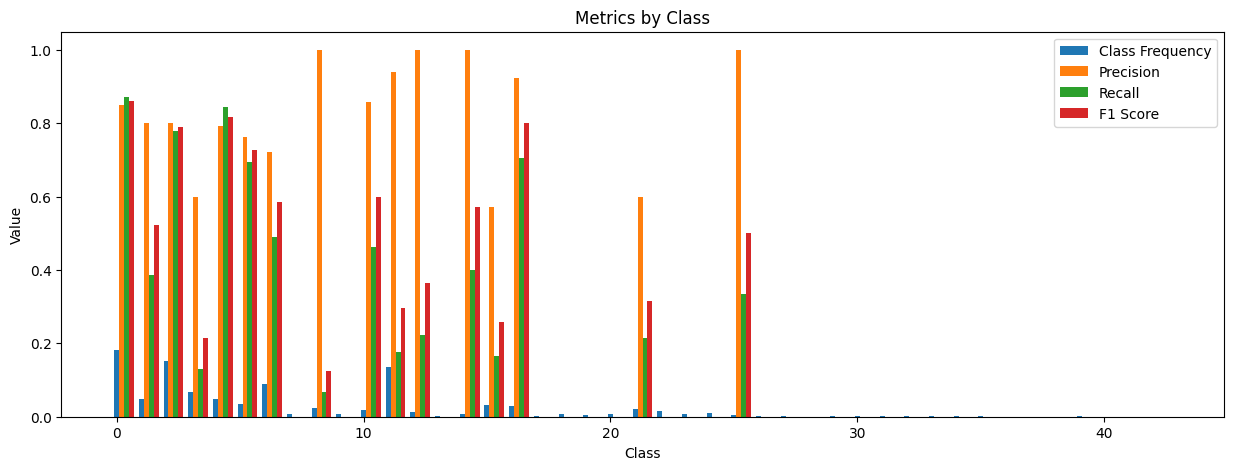

In [ ]:
bar_width = 0.2
index = np.arange(OUT_FINAL)
classes_count = classes_freq.drop(['HR', 'ODPM'])
classes_prob = classes_count / classes_count.sum()
classes_prob = classes_prob[::-1]

# Plotting the bars
plt.figure(figsize=(15,5))
plt.bar(index, classes_prob, width=bar_width, label='Class Frequency')
plt.bar(index + 1 * bar_width, test_result['precision'], width=bar_width, label='Precision')
plt.bar(index + 2 * bar_width, test_result['recall'], width=bar_width, label='Recall')
plt.bar(index + 3 * bar_width, test_result['f1'], width=bar_width, label='F1 Score')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Metrics by Class')
plt.legend()

From the chart, we can see that when the amount of data is decent the model performs prety well around 70% in F1 score. However, when the amount of data is small, there are two cases. The first one is that the model can still perform pertty well but Recall is far lower than Precision. The second case is that the model doens't learn about these classes at all. This problem welcomes further investigation. That's it for now, thank you!

# 📊 Model Performans Görselleştirmeleri (Sunum için)

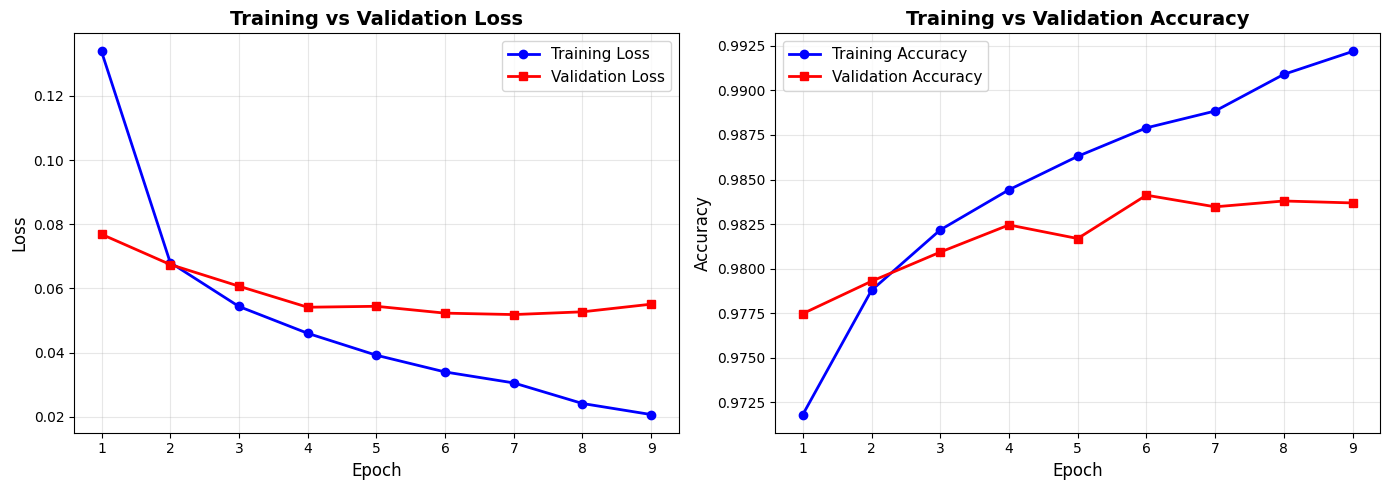

In [ ]:
# 1. Training & Validation Loss/Accuracy Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
train_losses = [r['loss'] for r in train_resi]
val_losses = [r['loss'] for r in val_resi]
epochs = range(1, len(train_losses) + 1)

axes[0].plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
train_accs = [r['acc'] for r in train_resi]
val_accs = [r['acc'] for r in val_resi]

axes[1].plot(epochs, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs, val_accs, 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 2. Multi-Label Confusion Matrix (Per-Class Binary Confusion)
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Tüm tahminleri ve gerçek değerleri topla
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Collecting predictions'):
        x = x.to(device)
        y_h = model(x)
        y_h = torch.sigmoid(y_h)  # Sigmoid uygula
        all_preds.append(y_h.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Binary predictions (threshold = 0.5)
all_preds_binary = (all_preds > 0.5).float()

# Sınıf isimleri
class_names = train_label_df.drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM']).columns.tolist()

print(f"Total test samples: {len(all_preds)}")
print(f"Number of classes: {len(class_names)}")

Total test samples: 640
Number of classes: 43


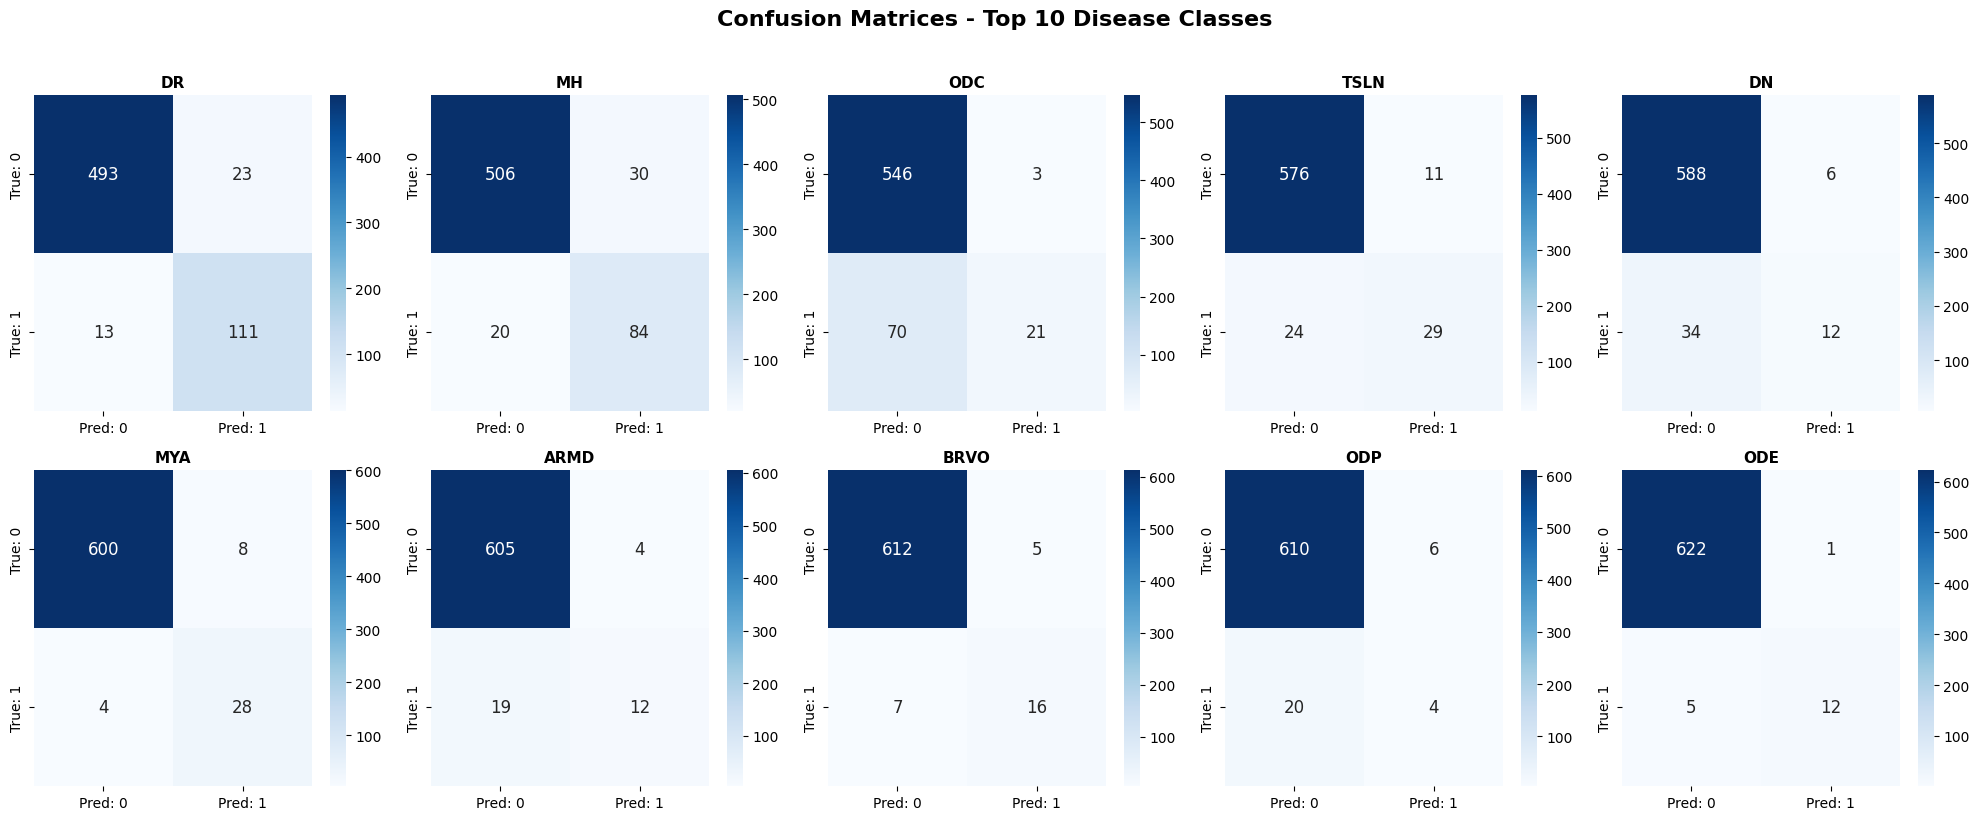

In [ ]:
# 3. Top-10 Hastalık Sınıfları için Confusion Matrix Grid
# En çok örneği olan 10 hastalığı seç
class_counts = train_label_df.drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM']).sum()
top_10_classes = class_counts.nlargest(10).index.tolist()
top_10_indices = [class_names.index(c) for c in top_10_classes]

# Multi-label confusion matrix hesapla
mcm = multilabel_confusion_matrix(all_labels.numpy(), all_preds_binary.numpy())

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (class_idx, class_name) in enumerate(zip(top_10_indices, top_10_classes)):
    cm = mcm[class_idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 12})
    axes[idx].set_title(f'{class_name}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - Top 10 Disease Classes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_top10.png', dpi=300, bbox_inches='tight')
plt.show()

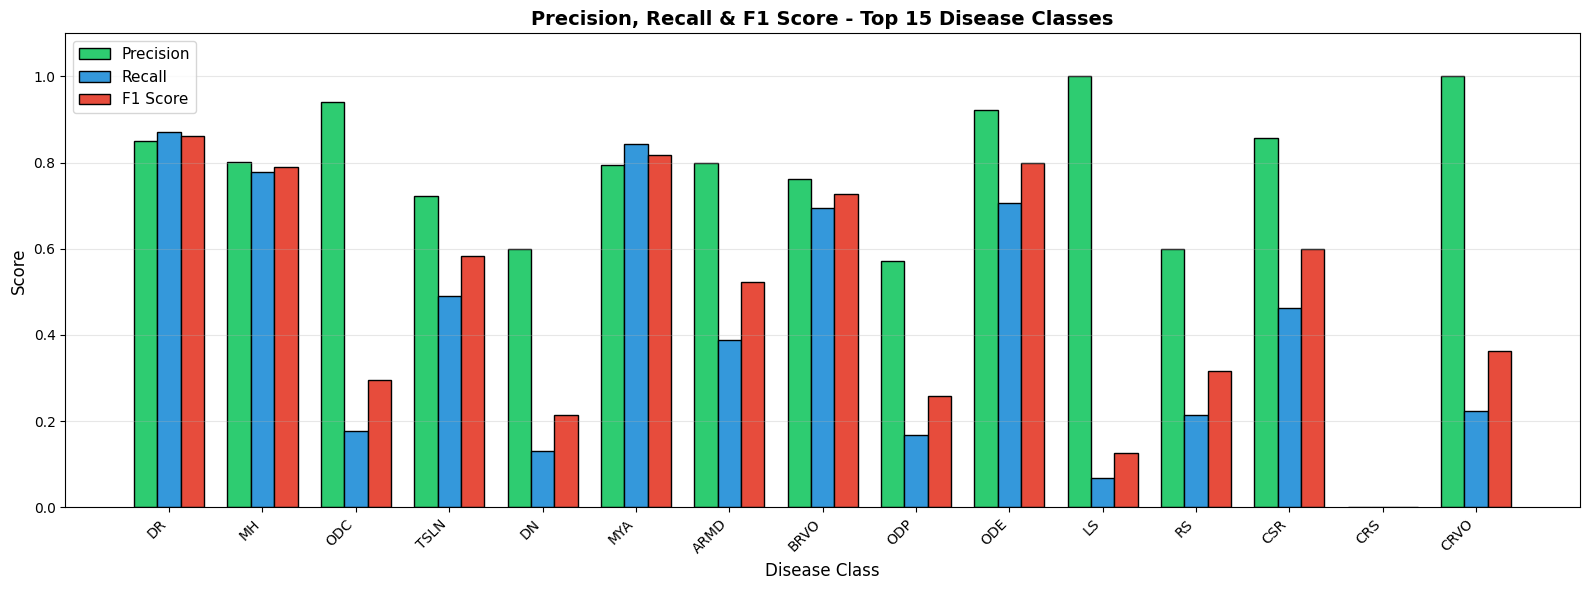

In [ ]:
# 4. Precision, Recall, F1 Score Bar Chart (Top 15 sınıflar)
top_15_classes = class_counts.nlargest(15).index.tolist()
top_15_indices = [class_names.index(c) for c in top_15_classes]

precision_top15 = test_result['precision'][top_15_indices].numpy()
recall_top15 = test_result['recall'][top_15_indices].numpy()
f1_top15 = test_result['f1'][top_15_indices].numpy()

x = np.arange(len(top_15_classes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x - width, precision_top15, width, label='Precision', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, recall_top15, width, label='Recall', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, f1_top15, width, label='F1 Score', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Disease Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision, Recall & F1 Score - Top 15 Disease Classes', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_15_classes, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('precision_recall_f1_top15.png', dpi=300, bbox_inches='tight')
plt.show()

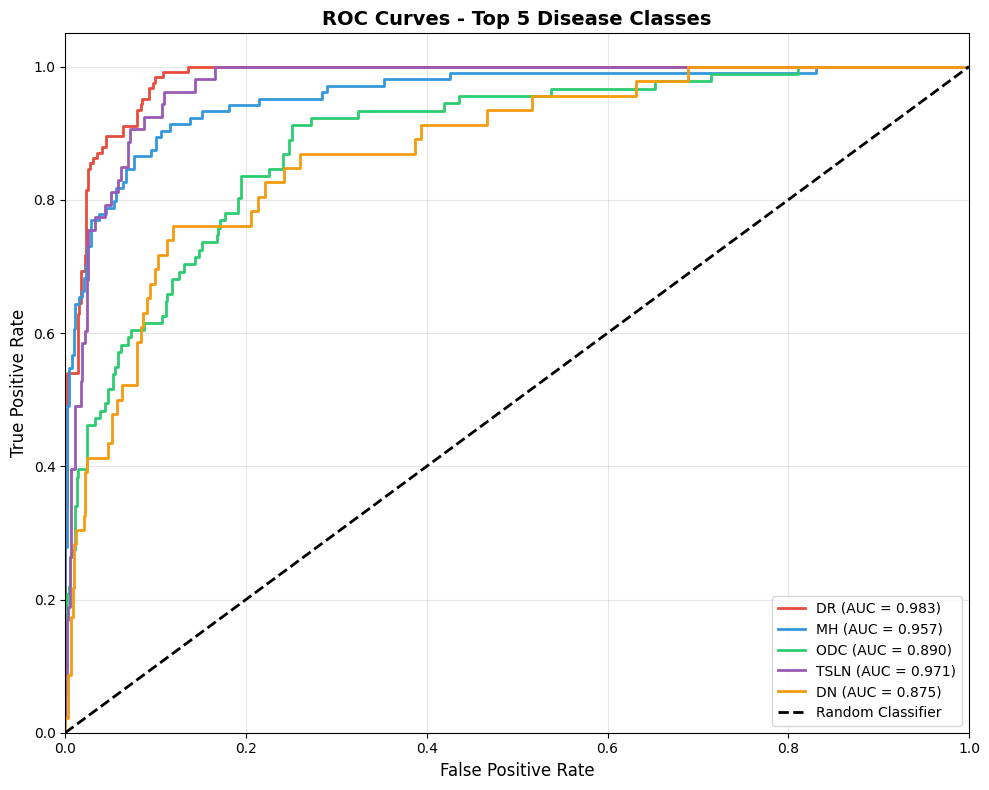

In [ ]:
# 5. ROC Curve - Top 5 hastalık sınıfları için
from sklearn.metrics import roc_curve, auc

top_5_classes = class_counts.nlargest(5).index.tolist()
top_5_indices = [class_names.index(c) for c in top_5_classes]

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']

for idx, (class_idx, class_name, color) in enumerate(zip(top_5_indices, top_5_classes, colors)):
    fpr, tpr, _ = roc_curve(all_labels[:, class_idx].numpy(), all_preds[:, class_idx].numpy())
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Top 5 Disease Classes', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_top5.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 6. Özet Performans Metrikleri Tablosu
from sklearn.metrics import classification_report

# Ortalama metrikler
avg_precision = test_result['precision'].mean().item()
avg_recall = test_result['recall'].mean().item()
avg_f1 = test_result['f1'].mean().item()

# Sadece pozitif örneği olan sınıflar için (daha gerçekçi)
nonzero_mask = test_result['f1'] > 0
avg_precision_nonzero = test_result['precision'][nonzero_mask].mean().item()
avg_recall_nonzero = test_result['recall'][nonzero_mask].mean().item()
avg_f1_nonzero = test_result['f1'][nonzero_mask].mean().item()

print("=" * 60)
print("📊 MODEL PERFORMANS ÖZETİ")
print("=" * 60)
print(f"\n🎯 Test Seti Sonuçları:")
print(f"   • Test Loss: {test_res['loss']:.4f}")
print(f"   • Test Accuracy: {test_res['acc']:.3f} ({test_res['acc']*100:.1f}%)")
print(f"\n📈 Tüm Sınıflar Üzerinden Ortalama:")
print(f"   • Macro Precision: {avg_precision:.3f}")
print(f"   • Macro Recall: {avg_recall:.3f}")
print(f"   • Macro F1 Score: {avg_f1:.3f}")
print(f"\n📈 Aktif Sınıflar Üzerinden Ortalama (F1 > 0):")
print(f"   • Macro Precision: {avg_precision_nonzero:.3f}")
print(f"   • Macro Recall: {avg_recall_nonzero:.3f}")
print(f"   • Macro F1 Score: {avg_f1_nonzero:.3f}")
print(f"\n📋 Toplam Sınıf Sayısı: {len(class_names)}")
print(f"   • Öğrenilen sınıflar (F1 > 0): {nonzero_mask.sum().item()}")
print(f"   • Öğrenilemeyen sınıflar (F1 = 0): {(~nonzero_mask).sum().item()}")
print("=" * 60)

📊 MODEL PERFORMANS ÖZETİ

🎯 Test Seti Sonuçları:
   • Test Loss: 0.0494
   • Test Accuracy: 0.985 (98.5%)

📈 Tüm Sınıflar Üzerinden Ortalama:
   • Macro Precision: 0.308
   • Macro Recall: 0.161
   • Macro F1 Score: 0.194

📈 Aktif Sınıflar Üzerinden Ortalama (F1 > 0):
   • Macro Precision: 0.826
   • Macro Recall: 0.434
   • Macro F1 Score: 0.522

📋 Toplam Sınıf Sayısı: 43
   • Öğrenilen sınıflar (F1 > 0): 16
   • Öğrenilemeyen sınıflar (F1 = 0): 27


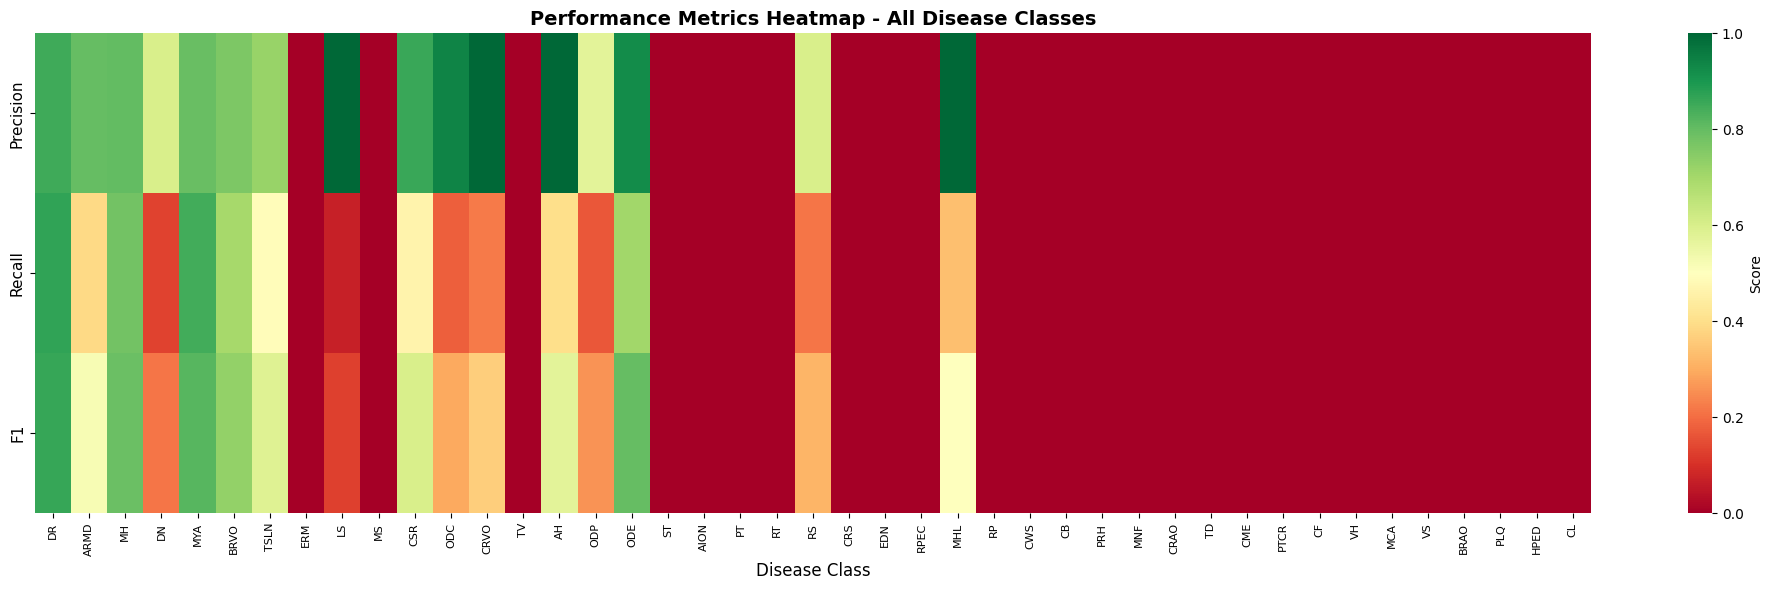

In [ ]:
# 7. Heatmap - Tüm Sınıflar için Precision/Recall/F1
fig, ax = plt.subplots(figsize=(20, 6))

# Metrikleri birleştir
metrics_data = np.stack([
    test_result['precision'].numpy(),
    test_result['recall'].numpy(),
    test_result['f1'].numpy()
])

sns.heatmap(metrics_data, annot=False, cmap='RdYlGn', ax=ax,
            xticklabels=class_names, yticklabels=['Precision', 'Recall', 'F1'],
            vmin=0, vmax=1, cbar_kws={'label': 'Score'})

ax.set_title('Performance Metrics Heatmap - All Disease Classes', fontsize=14, fontweight='bold')
ax.set_xlabel('Disease Class', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig('metrics_heatmap_all_classes.png', dpi=300, bbox_inches='tight')
plt.show()

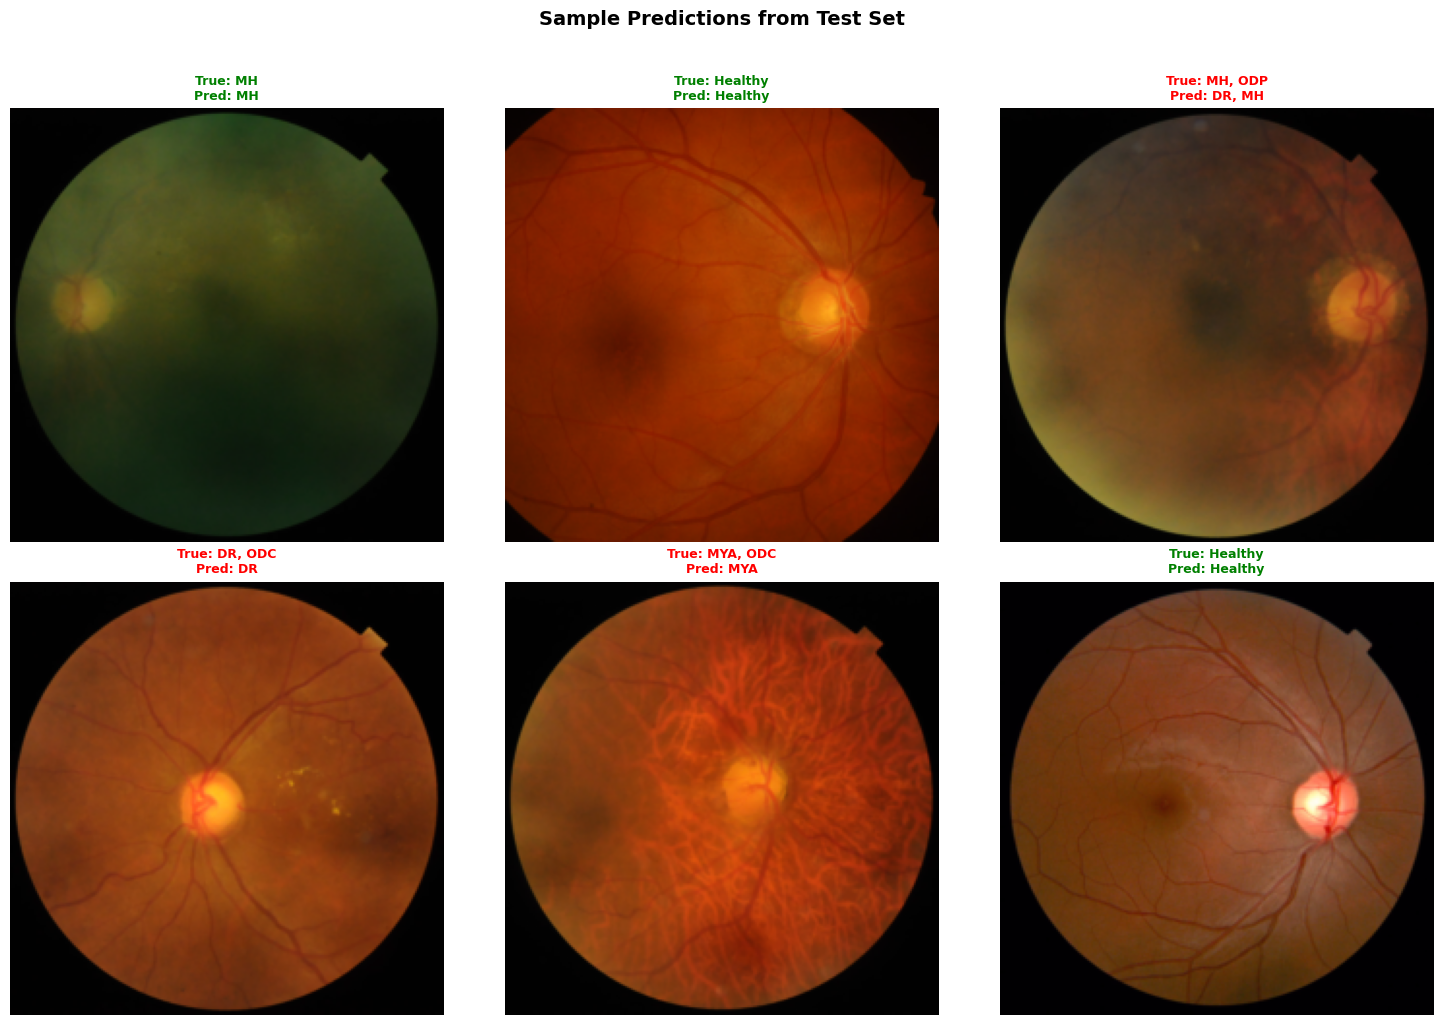

In [ ]:
# 8. Örnek Tahminler - Doğru ve Yanlış Örnekler Görselleştirme
import random

# Test setinden bazı örnekler al
sample_indices = random.sample(range(len(test_data)), 6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img, true_label = test_data[sample_idx]

    # Tahmin yap
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred).cpu().squeeze()

    # Görüntüyü denormalize et
    mean = torch.tensor(PRET_MEANS).view(3, 1, 1)
    std = torch.tensor(PRET_STDS).view(3, 1, 1)
    img_display = img * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    # Gerçek ve tahmin edilen hastalıklar
    true_diseases = [class_names[i] for i in range(len(class_names)) if true_label[i] == 1]
    pred_diseases = [class_names[i] for i in range(len(class_names)) if pred[i] > 0.5]

    axes[idx].imshow(img_display)
    axes[idx].axis('off')

    true_str = ', '.join(true_diseases) if true_diseases else 'Healthy'
    pred_str = ', '.join(pred_diseases) if pred_diseases else 'Healthy'

    # Başlık rengini belirle
    is_correct = set(true_diseases) == set(pred_diseases)
    color = 'green' if is_correct else 'red'

    axes[idx].set_title(f'True: {true_str}\nPred: {pred_str}',
                        fontsize=9, color=color, fontweight='bold')

plt.suptitle('Sample Predictions from Test Set', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

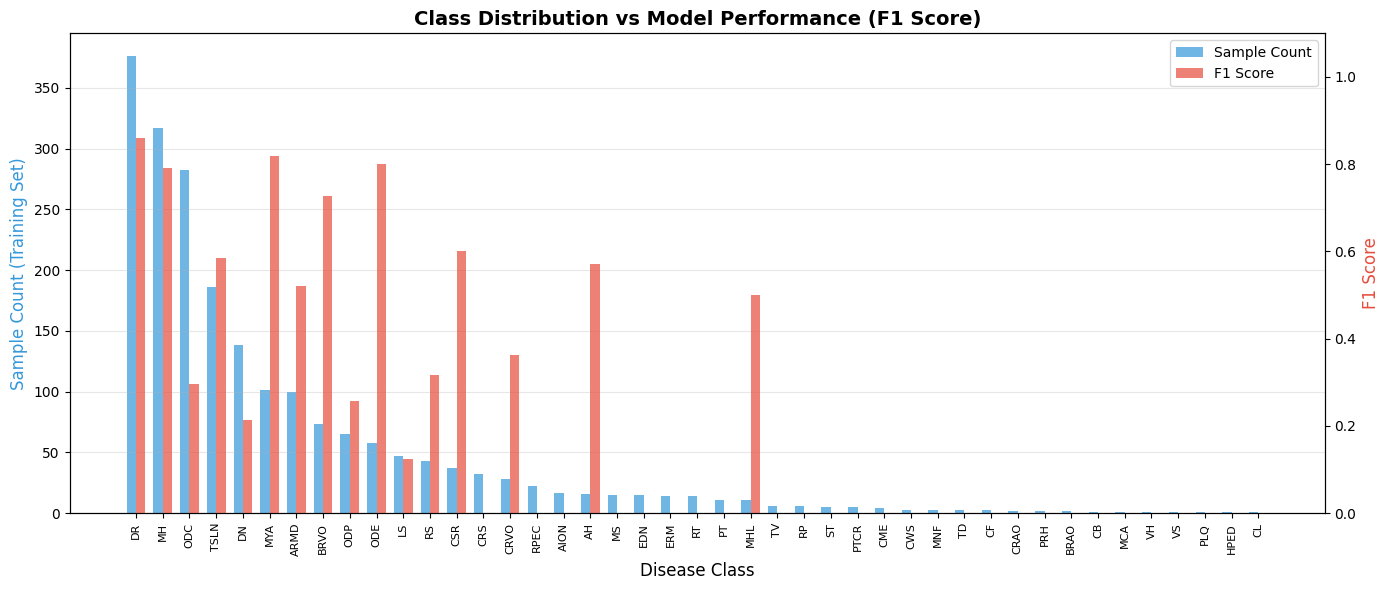

In [ ]:
# 9. Sınıf Dağılımı vs Model Performansı Karşılaştırması
fig, ax = plt.subplots(figsize=(14, 6))

# Sınıf sayıları ve F1 skorları
class_counts_sorted = class_counts.sort_values(ascending=False)
f1_sorted = [test_result['f1'][class_names.index(c)].item() for c in class_counts_sorted.index]

x = np.arange(len(class_counts_sorted))
width = 0.35

# İkili eksen
ax2 = ax.twinx()

bars1 = ax.bar(x - width/2, class_counts_sorted.values, width, label='Sample Count', color='#3498db', alpha=0.7)
bars2 = ax2.bar(x + width/2, f1_sorted, width, label='F1 Score', color='#e74c3c', alpha=0.7)

ax.set_xlabel('Disease Class', fontsize=12)
ax.set_ylabel('Sample Count (Training Set)', fontsize=12, color='#3498db')
ax2.set_ylabel('F1 Score', fontsize=12, color='#e74c3c')
ax.set_title('Class Distribution vs Model Performance (F1 Score)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_counts_sorted.index, rotation=90, fontsize=8)

# Legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('class_distribution_vs_performance.png', dpi=300, bbox_inches='tight')
plt.show()

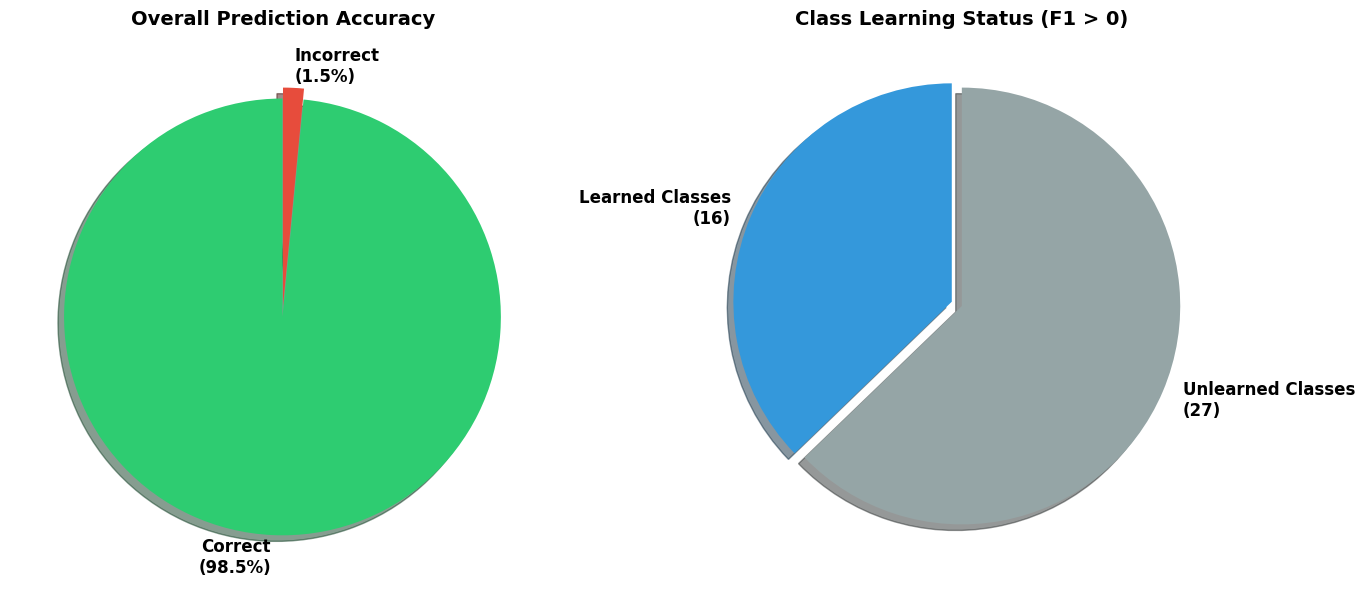


✅ Tüm grafikler başarıyla oluşturuldu ve kaydedildi!
📁 Kaydedilen dosyalar:
   • training_curves.png
   • confusion_matrices_top10.png
   • precision_recall_f1_top15.png
   • roc_curves_top5.png
   • metrics_heatmap_all_classes.png
   • sample_predictions.png
   • class_distribution_vs_performance.png
   • overall_performance_pie.png


In [ ]:
# 10. Pie Chart - Genel Model Başarısı
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sol: Accuracy pie chart
accuracy = test_res['acc']
sizes_acc = [accuracy, 1 - accuracy]
labels_acc = [f'Correct\n({accuracy*100:.1f}%)', f'Incorrect\n({(1-accuracy)*100:.1f}%)']
colors_acc = ['#2ecc71', '#e74c3c']
explode_acc = (0.05, 0)

axes[0].pie(sizes_acc, explode=explode_acc, labels=labels_acc, colors=colors_acc,
            autopct='', shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Overall Prediction Accuracy', fontsize=14, fontweight='bold')

# Sağ: Öğrenilen vs öğrenilemeyen sınıflar
learned = nonzero_mask.sum().item()
not_learned = (~nonzero_mask).sum().item()
sizes_class = [learned, not_learned]
labels_class = [f'Learned Classes\n({learned})', f'Unlearned Classes\n({not_learned})']
colors_class = ['#3498db', '#95a5a6']
explode_class = (0.05, 0)

axes[1].pie(sizes_class, explode=explode_class, labels=labels_class, colors=colors_class,
            autopct='', shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Learning Status (F1 > 0)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('overall_performance_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Tüm grafikler başarıyla oluşturuldu ve kaydedildi!")
print("📁 Kaydedilen dosyalar:")
print("   • training_curves.png")
print("   • confusion_matrices_top10.png")
print("   • precision_recall_f1_top15.png")
print("   • roc_curves_top5.png")
print("   • metrics_heatmap_all_classes.png")
print("   • sample_predictions.png")
print("   • class_distribution_vs_performance.png")
print("   • overall_performance_pie.png")